# Brief Description

The jupyter code below was used to analyze data for my paper published in the PNAS journal, titled, 'Continental freshwater discharge influences sea surface salinity variability near world's megadeltas'. 

The code uses Object Oriented Programming in Python to analyze statistical associations of continental streamflow and sea surface salinity near global mega deltas. In the code, a total number of 48 deltas were each read as objects and associated data were processed, analyzed, and partitioned into the objects to produce high impact figures. The hydrological variables (streamflow and water storage) were obtained from NASA's LIS and HyMAP models from the Goddard Space Flight Center's Discover supercomputer cluster. All other data used are publicly available from open access platforms. Below I provide a step-by-step sample of the code. To run the code, it is recommended to have all files saved in one directory, and to have access to necessary python libraries. Also, the user must download all input data before using any part of this code. 

Below I am listing most of the data sources used in this analysis, and mentioning the contact persons responsible for some of the raw data which I cannot share publicly. 

1. Processed Global SSS (NASA's SMAP sensor) and Streamflow (NASA's LIS and HyMAP models) data: 
Download from https://zenodo.org/records/14039482
Khadim, F., & Kumar, S. (2024). Analysis of streamflow and sea surface salinity near megadeltas [Data set]. Zenodo.

2. Reservoir storage data: 
contact Nishan Kumar Biswas (Associate Scientist, Earth Sciences)
Email: n.biswas@nasa.gov

3. Delta Shapefile data: 
Download from https://www.globaldeltarisk.net/data.html
Z.D. Tessler, C.J. Vörösmarty, M. Grossberg, I. Gladkova, H. Aizenman, J.P.M. Syvitski, E. Foufoula-Georgiou. Profiling Risk and Sustainability in Coastal Deltas of the World. Science 349(6248), 638-643 (2015) doi:10.1126/science.aab3574.

Further, I have uploaded some additional input files (.CSV file) in this github directory!

# Step 1. Load Modules and Directories

In [1]:
#import libraries as needed. 

import os
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.io
import matplotlib.pyplot as plt
import datetime as dt
import glob2
import rasterio
import matplotlib.dates as mdates
import seaborn as sns

from geopandas import GeoDataFrame
from netCDF4 import Dataset
from rasterio import plot as rasterplot
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import nearest_points
from scipy import stats
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from calendar import monthrange

warnings.filterwarnings('ignore')

#load all files in a director titled 'folder'. Then create sub-directories if needed to further organize the data


# Step 2. Define Classes and Methods

In [2]:
#Read the lis model inputs
lis_input=  folder + '/lis_input_010_hybrid.nc' 
lis_input = Dataset(lis_input,'r')


#load the streamflow data, processed into convenient lat x lon x time scales from raw HyMap simulations. This is monthly data.
dataset1 = scipy.io.loadmat('/global_Qs_monthly_2015_2021.mat')
Qs_monthly = dataset1['Streamflow_tavg']    
lat1 = dataset1['lat'][0]
lon1 = dataset1['lon'][0]

#load the surface water storage data, processed from the LIS model outcome
dataset11 = scipy.io.loadmat('/global_SWS_monthly_2015_2021.mat')
SWS_monthly = dataset11['SWS_tavg']/1000000 #convert into MCM units
    
#load the salnity data
dataset2 = scipy.io.loadmat('/global_SSS_monthly_2015_2021.mat')
SSS_monthly = dataset2['SSS_monthly']
lat2 = dataset2['lat'][0]
lon2 = dataset2['lon'][0]

#load the hycom model input data on sea surface precipitation, sea surface temperature and sea suface wind speed)
dataset3 = scipy.io.loadmat('/hycom_P_T_W.mat')
lat3 = dataset3['lat'][0]
lon3 = dataset3['lon'][0]
hycom = dataset3['hycom_data'][:,:,:,3:-2] #the original data is from January 2015, so we need to start indexing from April 2015, to match with the SSS and Streamflow overlapping period (April 2015 - October 2021)

#This is the master dataframe stored as a CSV file, which reads necessary basin information
df_master = pd.read_csv('/basin_data_deltas_taylor.csv')
df_master = df_master.drop(columns=['Unnamed: 0'])

#This is the basin raster file (originally modified from NASA's LIS and HyMap models)
basinfile = '/hymap_basins.tif'
basin = rasterio.open(basinfile).read()
basin = basin[0,::-1,:]
factor = np.where(basin>0,1,np.nan) #To assign the basin pixels as binary data

elev = np.array(lis_input.variables['ELEVATION']) #creating a variable for extracting basin elevation
elev[elev==-9999] = np.nan
elev = elev * factor

#Defining the Class 'Delta'. 

#Here, we want to define each delta, define domains with plume-length buffers around the delta outlets, and then extract 
#hydrological information for the specific domains. Lastly, the specific iformation will be stored in the Delta objects.
#The information to be extracted are generally, streamflow, SSS, reservoir storage, fluvial ratio. Detailed calculations are 
#involved within each extraction procedures.

class Delta:    
    Outlet_Coordinates = None #Coordinate of the Outlet of the Delta/Basin
    Outlet_Index = None #index of LIS grids of the outlet
    Basin_Outflow = None #Streamflow at the outlet of the Delta
    Basin_Storage = None #SWS averaged over the basin (m3)
    mean_Outflow = None #mean streamflow at the outlet (m3/s)
    stdev_Outflow = None #Standard deviation of outflow  at the outlet (m3/s)
    domain_1D = None #2D Domain of Salinity, typically selected around a radius 'r (default 5km)'
    domain_3D = None #3D Domain of Salinity,3rd dimension is time and a multiple of 12 months (84 in this code)
    hydomain_1D = None #2D domain of hycom data
    hydomain_3D = None #3D domain of hycom data
    
    positions = None  #Positions of the domain across the global grids
    area = None #Area of the Delta. This has to be revisited
    sss_array = None #3D Array of the Sea Surface Salinity (SSS)
    sss_ts = None #1D spatially averraged timeseries of the SSS
    Q_anomaly = None #Streamflow anomaly at outlet, 1D time series data
    sss_ts_anomaly = None #Anomaly of domain averaged SSS, 1D time series data
    Elev_range = None #range of elevation in km, within the basin
    Forrest_p = None #total percentage of forest cover. We did not use it in this study, but it maybe useful afterwards.
    
    
    precip_ts = None #79 months of spatially averaged precipitation
    surtmp_ts = None #79 months of spatially averaged surface temperature
    wndspd_ts = None #79 months of spatially averaged wind speed
    
    precip_ts_anomaly = None
    surtmp_ts_anomaly = None
    wndspd_ts_anomaly = None
    
    #Defining functions to use within the class 'Delta'
    
    def __init__(self, name, image):
        self.name = name
        self.image = image
        self.bounds = self.image.bounds 
        self.transform = self.image.transform[0]
        self.im = self.image.read() #abhijit

    def calculate_outflow(self):
        
        #This primary purpose of this function is to read the outflow at basin outlets (highest flow points within each basin grids)
        #and then extract the output as time-series data (79 months, not spatially distributed data). During the process, the function also 
        #averages other information within the basin, which are to be used later (e.g., averaging Elevation and Storage data to calculate)
        #Fluvial ratio, and basin-averaged Surface water storage data, respectively.
        
        gridcode = int(df_master[df_master['Delta']==self.name]['gridcode'])
        mask_y = np.where((lat1>self.bounds[1]) & (lat1 <self.bounds[3]))[0]
        mask_x = np.where((lon1>self.bounds[0]) & (lon1 <self.bounds[2]))[0]
        laty = lat1[mask_y]     
        lonx = lon1[mask_x]
        
        newArr = Qs_monthly[mask_y[0]:mask_y[-1],mask_x[0]:mask_x[-1],:]
        Qs_mean = np.nanmean(newArr,axis =2)
        Outlet_Index = (int(np.where(Qs_mean == np.nanmax(Qs_mean))[1]),int(np.where(Qs_mean == np.nanmax(Qs_mean))[0]))
        Outlet_Coordinates = (lonx[int(np.where(Qs_mean == np.nanmax(Qs_mean))[1])],laty[int(np.where(Qs_mean == np.nanmax(Qs_mean))[0])])
        Basin_Outflow = newArr[Outlet_Index[1],Outlet_Index[0],:]
        Elev_range = np.nanmax(elev*np.where(basin==gridcode,1,np.nan)) - np.nanmin(elev*np.where(basin==gridcode,1,np.nan))
        Forrest_p = np.nanmean(forrest*np.where(basin==gridcode,1,np.nan)) #this wasn't used later on
        
        #for basin-averaged storage
        newArr2 = SWS_monthly[mask_y[0]:mask_y[-1],mask_x[0]:mask_x[-1],:]
        newArr2 = np.transpose(newArr2,(2,0,1))
        SWS = np.nansum(np.nansum(newArr2,2),1)
       
        self.Outlet_Coordinates = Outlet_Coordinates
        self.Basin_Outflow = Basin_Outflow
        self.Basin_Storage = SWS
        
        self.mean_Outflow = np.nanmean(Basin_Outflow)
        self.stdev_Outflow = np.std(Basin_Outflow)
        self.Elev_range = Elev_range
        self.Forrest_p = Forrest_p

            
        
    def get_domain(self, r):
        
        #The purpose of this function is to extract the binary grids representative of a radial domain around the delta outlets.
        #Here, we specify the threshold plume-lengths, in degrees, and select all grids with radial distances below the threshold plume-length.
        
        coordinates = self.Outlet_Coordinates
        flow = self.Basin_Outflow
        
        positions = []
        for yy in np.arange(0,len(lat2)):
            for xx in np.arange(0,len(lon2)):
                if (lat2[yy]-coordinates[1])**2+(lon2[xx]-coordinates[0])**2 <= r**2:
                    positions.append((yy,xx))

        filler = SSS_monthly[:,:,0]
        sss_bound = np.where(filler > 0, 1, np.nan)
        
        domain_temp = np.empty([720,1440]); domain_temp[:] = np.nan; 

        for Y,X in positions:
            domain_temp[Y,X] = 1
            #print(Y,X)

        domain = domain_temp*sss_bound
        area = np.nansum(self.im[0,:,:])*((self.transform/0.25)**2)*770
        domain_3D = np.repeat(np.dstack((domain,domain)),42,axis=2)[:,:,0:79] #creating a 3D domain

        
        self.domain_1D = domain
        self.domain_3D = domain_3D

        self.positions = positions
        self.area = area      

        #to call this function
        #image =  mydict['Amazon']
        #domain1,positions, area = image.get_domain(image,5)

    def get_salinity(self, r):
        
        #This function extracts both spatipo-temporal and a time series (79) domain-averaged SSS
                
        domain_3D = self.domain_3D
        
        sss_array = SSS_monthly*domain_3D #raw array data, to make it sized 720,1440,84
            
        sss_ts = np.transpose(sss_array,(2,0,1))
        sss_ts = np.nanmean(np.nanmean(sss_ts,2),1)  #salinity timeseries data 1D array
                
        self.sss_array = sss_array
        self.sss_ts = sss_ts
        
        
        
    def get_hydomain(self, r):
        
        #This function extracts the domain for CFS-v2 weather data processing. Since the CFS data have a different grid size than SMAP
        #SSS data, we had to re-formulate the domain calculations.
        
        coordinates = self.Outlet_Coordinates
    
        positions = []
        for yy in np.arange(0,len(lat3)):
            for xx in np.arange(0,len(lon3)):
                if (lat3[yy]-coordinates[1])**2+(lon3[xx]-coordinates[0])**2 <= r**2:
                    positions.append((yy,xx))

        #filler = SSS_monthly[:,:,0]
        #sss_bound = np.where(filler > 0, 1, np.nan)
        
        domain = np.empty([880, 1760]); domain[:] = np.nan; 

        for Y,X in positions:
            domain[Y,X] = 1

        domain_3D = np.repeat(np.dstack((domain,domain)),42,axis=2)[:,:,0:79] #creating a 3D domain

        
        self.hydomain_1D = domain
        self.hydomain_3D = domain_3D

  
    def get_hycom(self, r):
        
        #This extracts the sea-surface climate forcings for specific domains
                
        domain_3D = self.hydomain_3D
        
        array = hycom[0,:,:,:]*domain_3D #raw array data, to make it sized 720,1440,8 
        precip_ts = np.transpose(array,(2,0,1))
        precip_ts = np.nanmean(np.nanmean(precip_ts,2),1)  #salinity timeseries data 1D array
        self.precip_ts = precip_ts

        array = hycom[1,:,:,:]*domain_3D #raw array data, to make it sized 720,1440,8 
        surtmp_ts = np.transpose(array,(2,0,1))
        surtmp_ts = np.nanmean(np.nanmean(surtmp_ts,2),1)  #salinity timeseries data 1D array
        self.surtmp_ts = surtmp_ts
        
        array = hycom[2,:,:,:]*domain_3D #raw array data, to make it sized 720,1440,8 
        wndspd_ts = np.transpose(array,(2,0,1))
        wndspd_ts = np.nanmean(np.nanmean(wndspd_ts,2),1)  #salinity timeseries data 1D array
        self.wndspd_ts = wndspd_ts
        
    def get_hycom_anomalies(self):
        
        #This extracts the sea-surface climate forcing anomalies for specific domains

        array1 = self.precip_ts
        array2 = self.surtmp_ts
        array3 = self.wndspd_ts
                
        months = len(array1)%12
        
        remaining_months = 12 - months
        #third dimension of the array should be the number of months       
        filler = np.empty(remaining_months)
        filler[:] = np.nan
        
        arr_resh1 = np.append(array1.flatten(),filler).reshape((7,12))
        arr_resh2 = np.append(array2.flatten(),filler).reshape((7,12))
        arr_resh3 = np.append(array3.flatten(),filler).reshape((7,12))

        arr_anomaly1 = arr_resh1
        arr_anomaly2 = arr_resh2
        arr_anomaly3 = arr_resh3

        arr_av1 = np.nanmean(arr_resh1, axis = 0)
        arr_av2 = np.nanmean(arr_resh2, axis = 0)
        arr_av3 = np.nanmean(arr_resh3, axis = 0)


        for x in np.arange(0,months):
            arr_anomaly1[x,:] = arr_resh1[x,:] - arr_av1
            arr_anomaly2[x,:] = arr_resh2[x,:] - arr_av2
            arr_anomaly3[x,:] = arr_resh3[x,:] - arr_av3

        arr_anomaly1 = arr_anomaly1.reshape((7*12,1)).flatten()[0:len(array1)]
        arr_anomaly2 = arr_anomaly2.reshape((7*12,1)).flatten()[0:len(array2)]
        arr_anomaly3 = arr_anomaly3.reshape((7*12,1)).flatten()[0:len(array3)]
        
        self.precip_ts_anomaly = arr_anomaly1
        self.surtmp_ts_anomaly = arr_anomaly2
        self.wndspd_ts_anomaly = arr_anomaly3        
        
    def calculate_deseasoned_anomaly(self):
        
        #This function calculates the anomalies for streamflow and SSS
        
        array1 = self.Basin_Outflow
        array2 = self.sss_ts
        
        #first array is streamflow at the outlet, second array is salinity average time series
        
        months = len(array1)%12
        
        remaining_months = 12 - months
        #third dimension of the array should be the number of months       
        filler = np.empty(remaining_months)
        filler[:] = np.nan
        
        arr_resh1 = np.append(array1.flatten(),filler).reshape((7,12))
        arr_resh2 = np.append(array2.flatten(),filler).reshape((7,12))

        arr_anomaly1 = arr_resh1
        arr_anomaly2 = arr_resh2

        arr_av1 = np.nanmean(arr_resh1, axis = 0)
        arr_av2 = np.nanmean(arr_resh2, axis = 0)


        for x in np.arange(0,months):
            arr_anomaly1[x,:] = arr_resh1[x,:] - arr_av1
            arr_anomaly2[x,:] = arr_resh2[x,:] - arr_av2



        arr_anomaly1 = arr_anomaly1.reshape((7*12,1)).flatten()[0:len(array1)]
        arr_anomaly2 = arr_anomaly2.reshape((7*12,1)).flatten()[0:len(array2)]
        

        self.Q_anomaly = arr_anomaly1
        self.sss_ts_anomaly = arr_anomaly2        



In [98]:
#This is the master dataframe which is loaded in the earlier code
df_master

,DeltaID,Delta,gridcode,MEAN_temp,dam_count,dam_area,basin_area,dam_area_percent,gauge,status,Climate_Code,Wave_H,Wave_T,Lon_gauge,Lat_gauge,gauge_area,gauge_R,gauge_stdv,XY_annotate,XY_coordinate
0,1,Amazon,1452,24.681,7,2623.2,4.853135e+06,0.054052,610238503.0,gauged,1,0.514444,2.776869,-55.5131,-1.9192,4671740.500,0.946487,0.209453,"(-48, 15)","(-50.75, -0.4500007629394531)"
1,2,Amur,3376,-0.279,6,2583.8,2.334644e+06,0.110672,NaN,ungauged,26,0.546084,2.700663,NaN,NaN,NaN,NaN,NaN,"(150, 60)","(140.75, 53.14999771118164)"
2,3,Brahmani,2028,23.938,4,53.6,4.294270e+04,0.124817,NaN,ungauged,3,0.512335,2.334714,NaN,NaN,NaN,NaN,NaN,"(70, 40)","(86.54998779296875, 20.450000762939453)"
3,4,Burdekin,2679,22.255,3,219.3,1.141075e+05,0.192187,531279841.0,gauged,3,0.690380,2.865581,147.2438,-19.7646,129877.969,0.890528,0.030431,"(140, -30)","(147.45001220703125, -19.650001525878906)"
4,5,Chao_Phraya,1355,25.462,10,725.8,1.314266e+05,0.552247,NaN,ungauged,3,0.581691,2.567522,NaN,NaN,NaN,NaN,NaN,"(60, -30)","(100.6500244140625, 13.549999237060547)"
5,6,Colorado,827,11.703,85,1486.2,6.308134e+05,0.235601,700771465.0,gauged,4,0.530530,2.422004,-111.5896,36.8646,283217.656,0.340129,0.184047,"(-131, 21)","(-114.8499755859375, 31.85000228881836)"
6,7,Congo,365,23.450,5,411.4,3.001319e+06,0.013707,NaN,ungauged,3,0.472678,2.311197,NaN,NaN,NaN,NaN,NaN,"(-5, -20)","(12.95001220703125, -5.950000762939453)"
7,8,Danube,5224,8.750,183,1256.1,9.310694e+05,0.134909,210592462.0,gauged,7,0.481778,2.327527,13.5021,48.5813,76860.469,0.746382,0.204135,"(20, 75)","(29.6500244140625, 45.250003814697266)"
8,9,Dnieper,5379,7.414,6,5685.9,6.609589e+05,0.860250,NaN,ungauged,7,0.486941,2.339205,NaN,NaN,NaN,NaN,NaN,"(40, 60)","(32.45001220703125, 46.54999923706055)"
9,10,Ebro,1762,11.900,45,272.7,9.335254e+04,0.292118,NaN,ungauged,7,0.461485,2.246699,NaN,NaN,NaN,NaN,NaN,"(-21, 45)","(0.8499755859375, 40.750003814697266)"


Normal function for anomaly

# Step 3. Defining Deltas as objects

In [3]:
# This block of code stores all the attributes of the image files in the dictionary "mydict", as different objects. 
#Basically, we loop through the raster TIFF files of the global deltas, and then calculate SSS, Streamflow, etc., and store
#them as objects within the "mydict". This way, when you call mydict['Amazon'], only information for the Amazon delta will appear.
#For example, printing: mydict['Amazon'].Basin_Outflow; will provide 1D timeseries data of basin averaged streamflow for Amazon.

start_time = datetime.now()

mydict = {}

files=sorted(glob2.glob(folder_map+'/*.tiff'))
files = files[:-2]

obj_delta = None

for file in files:
    delta = file.split('_app')[0].split('/')[5]
    #print(delta)
    obj_delta = Delta('%s'%(delta),rasterio.open(file))
    obj_delta.calculate_outflow()
    obj_delta.get_domain(5)
    obj_delta.get_salinity(5)
    obj_delta.calculate_deseasoned_anomaly()

    mydict['%s'%(delta)]= obj_delta
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))



Duration: 0:04:17.252642


# Step 4. Creating the master dataframe with statistical results

In [5]:
#This block of code extracts the necessary statistical metrices (Pearson's R, p-value, mean outflow, standard deviation of outflow, basin outlet coordinates, etc.)

start_time = datetime.now() #This is not necessary, it's just used to print the time needed to run the code.

cols = ['delta', 'area', 'R', 'R_anomaly', 'p1', 'p2', 'coordinate', 'mean', 'stdev']
lst = []

for keys in mydict.keys():
    image = mydict['%s'%(keys)]
    #print(keys)
    
    try:
        Arr1 = np.transpose(np.array([image.Basin_Outflow, image.sss_ts]))
        Arr1 = Arr1[~np.isnan(Arr1).any(axis=1)]

        r1 = stats.pearsonr(Arr1[:,0], Arr1[:,1])[0]
        p1 = stats.pearsonr(Arr1[:,0], Arr1[:,1])[1]

        Arr2 = np.transpose(np.array([image.Q_anomaly, image.sss_ts_anomaly]))
        Arr2 = Arr2[~np.isnan(Arr2).any(axis=1)]

        r2 = stats.pearsonr(Arr2[:,0], Arr2[:,1])[0]
        p2 = stats.pearsonr(Arr2[:,0], Arr2[:,1])[1]
    
    except:
        r1 = np.nan
        p1= np.nan
        r2 = np.nan
        p2 = np.nan

    
    mean = image.mean_Outflow
    stdev = image.stdev_Outflow
    
    lst.append([keys, image.area, r1, r2, p1, p2, Point(image.Outlet_Coordinates), mean, stdev])
    
df1 = pd.DataFrame(lst, columns=cols)
df1['Delta'] = df1['delta']

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

df_new = df1.copy()

# Categorizing the p-values
for i, item in enumerate(df_new['delta']):
    #print(item)
    
    if df_new['p1'][i] <= 0.01:
        df_new['p1'][i] = 'p1<=0.01'
    elif df_new['p1'][i] > 0.01:
        df_new['p1'][i] = 'p1>0.01'
    else:
        df_new['p1'][i] = 'N/A'
        

    if df_new['p2'][i] <= 0.01:
        df_new['p2'][i] = 'p2<=0.01'
    elif df_new['p2'][i] > 0.01:
        df_new['p2'][i] = 'p2>0.01'
    else:
        df_new['p2'][i] = 'N/A'

df_new['delta_loc'] = df_new['delta']
df_new['lat'] = df_new['delta']#for sorting

for i, item in enumerate(df_new['coordinate']):

    x,y = int(item.x), int(item.y)
    df_new['delta_loc'][i] = df_new['delta'][i]+":("+str(y)+"N,"+str(x)+"E)"
    #df_new['delta_loc'][i] = df_new['delta'][i]+"; "+df_new['p1'][i]+","+df_new['p2'][i]+")"

    df_new['lat'][i] = y

df_new = df_new[df_new['R'].notna()]    
df_new = df_new.sort_values(by=['mean'], ascending = True)    
df_new = df_new.reset_index(drop=True)

df1['DeltaID'] = np.arange(1,49)


df_tag = df1[['DeltaID','Delta']].copy()
df_tag

Duration: 0:00:00.196520


,DeltaID,Delta
0,1,Amazon
1,2,Amur
2,3,Brahmani
3,4,Burdekin
4,5,Chao_Phraya
5,6,Colorado
6,7,Congo
7,8,Danube
8,9,Dnieper
9,10,Ebro


In [24]:
df1

,delta,area,R,R_anomaly,p1,p2,coordinate,mean,stdev,Delta,DeltaID
0,Amazon,106509.836061,-0.725564,-0.561204,3.922939e-14,7.451335e-08,POINT (-50.75 -0.4500007629394531),196639.857107,107685.211531,Amazon,1
1,Amur,2397.105533,0.227238,0.114557,5.490528e-02,3.379653e-01,POINT (140.75 53.14999771118164),14316.630037,7580.555118,Amur,2
2,Brahmani,6508.766136,-0.782481,0.135060,1.653877e-17,2.353242e-01,POINT (86.54998779296875 20.450000762939453),2102.390152,2607.834428,Brahmani,3
3,Burdekin,1283.271655,-0.518356,-0.373790,9.922400e-07,6.906812e-04,POINT (147.45001220703125 -19.650001525878906),347.121197,475.239739,Burdekin,4
4,Chao_Phraya,24058.886096,-0.409527,-0.244714,1.784543e-04,2.973847e-02,POINT (100.6500244140625 13.549999237060547),1213.245795,1282.021212,Chao_Phraya,5
5,Colorado,10002.328648,-0.204333,-0.002720,7.086913e-02,9.810178e-01,POINT (-114.8499755859375 31.85000228881836),278.979083,92.409905,Colorado,6
6,Congo,2211.468899,-0.419935,-0.426886,1.168299e-04,8.735703e-05,POINT (12.95001220703125 -5.950000762939453),58066.879512,19741.389912,Congo,7
7,Danube,6375.642320,-0.369536,-0.154559,8.033721e-04,1.738162e-01,POINT (29.6500244140625 45.250003814697266),6619.884058,3633.790084,Danube,8
8,Dnieper,1097.990301,-0.133003,0.024614,2.426002e-01,8.295172e-01,POINT (32.45001220703125 46.54999923706055),2851.445336,2690.838437,Dnieper,9
9,Ebro,682.261606,-0.194851,0.032129,8.528682e-02,7.786444e-01,POINT (0.8499755859375 40.750003814697266),292.613352,224.805956,Ebro,10


# Step 5. Main figures for the paper (Figure 1 - Figure 3)

To run the following codes, we need to perform a sensitivity analysis, where we re-run step 3 and step 4 of this code, using different time-lags and plume-length gradients. 

The outcome is stored as four different .mat files, 

dict_lag_distance.mat (R values only), 
dict_lag_distance_p.mat (p-values only), 
dict_lag_distance_anomaly.mat (R values for anomalies), 
dict_lag_distance_anomaly_p.mat (p-values for anomalies). 

The increments used to run the sensitivity test is, +1 month from -3 to +3 (time-lags), and +1 degree for 0 to 15 degrees. Unfortunately, I don't have access to the code for this block of sensitivity analysis, but this is easy to do, just re-run Step 4 and Step 5 for the increments mentioned. The outcomes will be an array of shape (15,7). 15-length increments (0 to 15-degrees), and 7 monthly lags from -3 to +3.

# Figure 1

In [6]:
dataset = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance.mat')
dataset_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_p.mat')

dataset_anomaly = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly.mat')
dataset_anomaly_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly_p.mat')


list_ = []
for x in dataset.keys():
    if x[0] != '_':
        list_.append(x)
        
delta=[]
R_max = []
R_anomaly = []
p_val = []
p_val_anomaly = []
optimized_distance = []
optimized_lag = []
#area = []
#mean_streamflow = []

for keys in list_:
    
    delta.append(keys)
    
    posval = np.nanmax(dataset[keys]) #[:,3:] is for considering only positive lags # 
    negval = np.nanmin(dataset[keys])
    if np.greater(np.abs(posval),np.abs(negval)):
        #print(posval)
        R = posval
    else:
        #print(negval)
        R = negval
    try:
        x = int(np.where(dataset[keys]==R)[0])
        y = int(np.where(dataset[keys]==R)[1])
    except:
        x = np.nan
        y = np.nan
        
    x1 = x+1
    y1 = y-3 #y-3
    #y1 = 0
    
    #print(keys)
    #area.append(float(df1.loc[df1['delta'] == keys]['area']))
    #mean_streamflow.append(float(df1.loc[df1['delta'] == keys]['mean']))
    
    p_m = dataset_p[keys]
    p_m2 = dataset_anomaly_p[keys]
    R_2 = dataset_anomaly[keys]
    try:
        p_val.append(p_m[x,y]) 
        p_val_anomaly.append(p_m2[x,y])
        R_anomaly.append(R_2[x,y])
        
        #p_val.append(p_m[x]) 
        #p_val_anomaly.append(p_m2[x])
        #R_anomaly.append(R_2[x])
    
    except:
        p_val.append(np.nan)
        p_val_anomaly.append(np.nan)
        R_anomaly.append(np.nan)
        
    R_max.append(R)
    
    
    optimized_distance.append((x1))
    optimized_lag.append((y1))
    
    #lag.append(np.nanmax(dataset[keys]))
    #distance.append()

df_lag = pd.DataFrame(
    {'delta': delta,
     'R_max': R_max,
     'p_val': p_val,
     'R_anomaly': R_anomaly,
     'p_val_anomaly': p_val_anomaly,
     'optimized_distance': optimized_distance,
     'optimized_lag': optimized_lag,
     
    })


df_lag

,delta,R_max,p_val,R_anomaly,p_val_anomaly,optimized_distance,optimized_lag
0,Amazon,-0.908940,1.333549e-30,-0.527817,6.841024e-07,6.0,-1.0
1,Amur,-0.629721,7.397166e-07,-0.554199,2.450922e-05,4.0,1.0
2,Brahmani,-0.782481,1.653877e-17,0.135060,2.353242e-01,6.0,0.0
3,Burdekin,-0.719533,7.980307e-14,-0.709575,2.477502e-13,2.0,0.0
4,Chao,-0.771927,2.070629e-16,-0.335644,2.843442e-03,5.0,-2.0
5,Colorado,0.527111,9.987931e-07,0.156506,1.769795e-01,15.0,3.0
6,Congo,-0.689891,2.828472e-12,-0.433680,7.295325e-05,12.0,-1.0
7,Danube,-0.459774,2.288214e-05,0.038092,7.405647e-01,2.0,1.0
8,Dnieper,0.310408,6.352957e-03,0.310344,6.364392e-03,15.0,3.0
9,Ebro,-0.532150,6.330712e-07,-0.129309,2.623563e-01,7.0,2.0


In [8]:
XY_annotate = []
XY_coordinate = []

for item2, item in df1.iterrows():
    XY_annotate.append((item['coordinate'].x-12,item['coordinate'].y-10))
    XY_coordinate.append((item['coordinate'].x,item['coordinate'].y))
    
    
df_master['XY_annotate'] = XY_annotate
df_master['XY_coordinate'] = XY_coordinate

df_master['XY_annotate']

(item['coordinate'].x-12,item['coordinate'].y-10)


#For plot annotation, this is where the arrow starts from

XY_annotate = [(-48, 15), #Amazon
 (150, 60), #Amur
 (70, 40), #Brahmani
 (140, -30), #Burdekin
 (60, -30), #Chao
 (-131, 21), #Colorado
 (-5, -20), #Congo
 (20, 75), #Danube 
 (40, 60), #Dneiper
 (-21, 45), #Ebro
 (155, -10), #Fly
 (85, 55), #Ganges
 (60, 0), #Goddavari
 (-108, 9), #Grijalva
 (125,50), #Han
 (135, 7), #Hong
 (55, 14), #Indus
 (58, -15), #Irrawaddy
 (55, 5), #Krishna
 (105, 70), #Lena
 (31, -35), #Limpopo
 (-120, 60), #Mackenzie
 (-95, 1), #Magdalena
 (130, 0), #Mahakam
 (60, 30), #Mahanadi
 (100, -20), #Mekong
 (-90, 40), #Mississippi
 (-4, 25), #Moulouya
 (-6, -5), #Niger
 (45, 19), #Nile
 (-74, 25), #Orinoco
 (-50, -50), #Parana
 (130, 14), #Pearl
 (0, 70), #Po
 (-8, 57), #Rhine
 (-40, 60), #Rhone
 (-141, 0), #Rio
 (-48, -30), #Sao
 (-40, 30), #Sebou
 (-38, 5), #Senegal
 (50, 45), #Shatt
 (48, -10), #Tana
 (150, 40), #Tone
 (7, 65), #Vistula
 (-22, -4), #Volta
 (140, 20), #Yangtze
 (110, 60), #Yellow
 (-165, 53)] #Yukon

df_master['XY_annotate'] = XY_annotate


In [15]:
from geopandas import GeoDataFrame
gdf = GeoDataFrame(df_lag['R_max'],geometry = df1['coordinate'])

XY_anomaly = []

for item2, item in df1.iterrows():
    XY_anomaly.append(Point(item['coordinate'].x+3,item['coordinate'].y-2))

gdf2 = GeoDataFrame(df_lag['R_anomaly'],geometry = XY_anomaly)

#world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#hymap_basin4.shp
#glob_image = rasterio.open(folder_map+'/global_map_2.5min.tiff')
#glob_data = glob_image.read()[0,:,:]
#extent = np.array([-180,180,-90,90])
#glob_data = np.where(glob_data == 255,0,1)
world = gpd.read_file(folder_map+"/globalislandsshapefile/Global_Islands.shp")
basin_gdf = gpd.read_file("/discover/nobackup/fkhadim/hymap_basin4.shp")

color = []
for c in df_lag['R_max']:
    if c<0:
        color.append('Blue')
    else:
        color.append('Red')
        

for c in np.arange(len(df_lag['p_val'])):
    if df_lag['p_val'][int(c)]>0.05:
        color[c] = 'Black'        
        
color2 = []
for c in df_lag['R_anomaly']:
    if c<0:
        color2.append('Blue')
    else:
        color2.append('Red')

for c in np.arange(len(df_lag['p_val_anomaly'])):
    if df_lag['p_val_anomaly'][int(c)]>0.05:
        color2[c] = 'Black'  
        

#marker = []
#for m in color: marker.append('x') if m == 'Grey' else marker.append('o')
        
fig, ax = plt.subplots(figsize = (12,6))

ax.set_aspect('equal')
ax.set_xlim([-170,170])
ax.set_ylim([-80,85])
#ax.set_xlim([-50,50])
#ax.set_ylim([25,50])


#ax[1].set_title('Correlation Coefficients of Outflow and Sea Surface Salinity')
world.plot(ax=ax, facecolor='w', edgecolor='k', alpha=0.4, lw=0.5)
basin_gdf.plot(ax=ax, facecolor='blue', alpha=0.1, edgecolor='blue', lw=1)
gdf.plot(column='R_max', ax=ax, color=color, edgecolor='yellow', 
         markersize = np.absolute(df_lag['R_max'])*300)
gdf2.plot(column='R_anomaly', ax=ax, color=color2, edgecolor='yellow',
         marker = 'D' , markersize = np.absolute(df_lag['R_anomaly'])*300)



custom_lines = [Line2D([0], [0], color='Blue', marker='o', lw=0, markersize = 10, label = '-ve Correlation'),
                Line2D([0], [0], color='Red', marker='o', lw=0, markersize = 10, label = '+ve Correlation'),
                Line2D([0], [0], color='White', marker='D', markeredgecolor='orange', lw=1, markersize = 10,  
                       label='De-seasoned anomaly'),
                Line2D([0], [0], color='Black', marker='o', lw=0, markersize = 10, label = 'not significant at 5% level'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=8,label = 'R=0.25'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=12,label = 'R=0.5'),                
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=16,label = 'R=0.75'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=20,label = 'R=1')]

plt.legend(handles=custom_lines, loc='lower right', ncol=4, fontsize = 14)

for ind, row in df_master.iterrows():
    ax.annotate("%s"%row['Delta'].replace('_',' '), xy=row['XY_coordinate'], 
                xytext=row['XY_annotate'], fontsize=10,
                arrowprops={"arrowstyle":"-", "color":"gray"})
                #bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8, 0.5), ec="none"),


#plt.text(-20, 20, 'o', fontsize=100, bbox=dict(facecolor='none', alpha=0.5))
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

plt.savefig('/discover/nobackup/fkhadim/Figure1_optimallag.png', dpi=600)

plt.show


NameError: name 'df_lag' is not defined

## Gauged Basins Only

<function matplotlib.pyplot.show(close=None, block=None)>

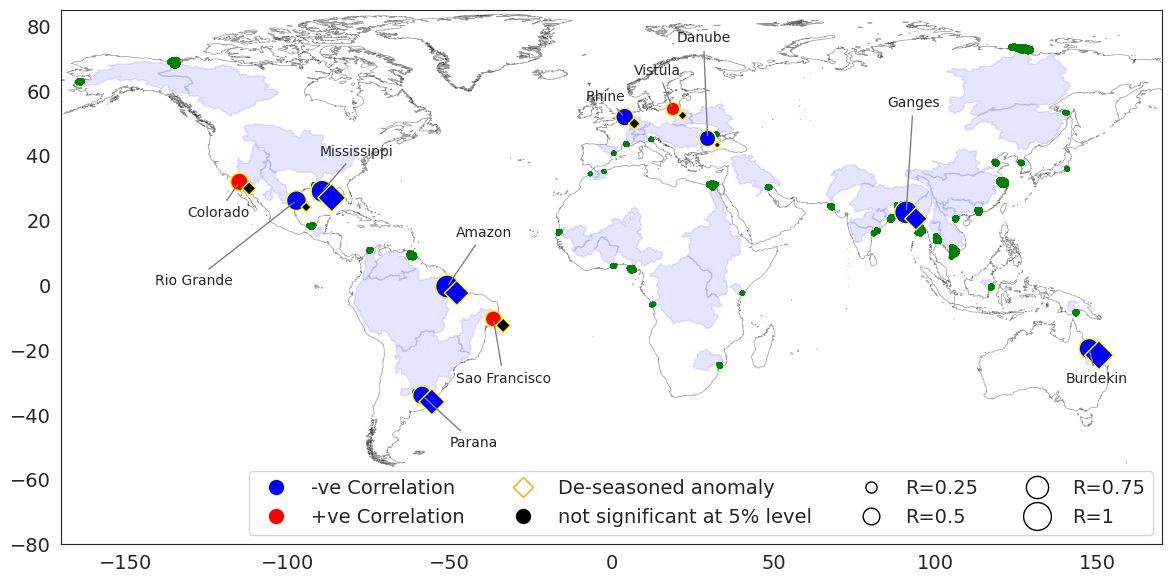

In [71]:
df_master['coordinate'] = df1['coordinate']
df_master['R_max'] = df_lag['R_max']
df_master['R_anomaly'] = df_lag['R_anomaly']
df_master['p_val'] = df_lag['p_val']
df_master['p_val_anomaly'] = df_lag['p_val_anomaly']

df_master2 = df_master.dropna()

from geopandas import GeoDataFrame
gdf = GeoDataFrame(df_master2['R_max'],geometry = df_master2['coordinate'])
deltas = gpd.read_file("/discover/nobackup/fkhadim/maps/global_map.shp")

XY_anomaly = []

for item2, item in df_master2.iterrows():
    XY_anomaly.append(Point(item['coordinate'].x+3,item['coordinate'].y-2))

gdf2 = GeoDataFrame(df_master2['R_anomaly'],geometry = XY_anomaly)

#world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#hymap_basin4.shp
#glob_image = rasterio.open(folder_map+'/global_map_2.5min.tiff')
#glob_data = glob_image.read()[0,:,:]
#extent = np.array([-180,180,-90,90])
#glob_data = np.where(glob_data == 255,0,1)

world = gpd.read_file(folder_map+"/globalislandsshapefile/Global_Islands.shp")
basin_gdf = gpd.read_file("/discover/nobackup/fkhadim/hymap_basin4.shp")

color = []
for c in df_master2['R_max']:
    if c<0:
        color.append('Blue')
    else:
        color.append('Red')
        

k = 0
for i,c in df_master2.iterrows():
    if c['p_val']>0.05:
        color[k] = 'Black'
    k = k+1
        
     
        
color2 = []
for c in df_master2['R_anomaly']:
    if c<0:
        color2.append('Blue')
    else:
        color2.append('Red')

k = 0
for i,c in df_master2.iterrows():
    if c['p_val_anomaly']>0.05:
        color2[k] = 'Black'
    k = k+1
        

#marker = []
#for m in color: marker.append('x') if m == 'Grey' else marker.append('o')
        
fig, ax = plt.subplots(figsize = (12,6))

ax.set_aspect('equal')
ax.set_xlim([-170,170])
ax.set_ylim([-80,85])
#ax.set_xlim([-50,50])
#ax.set_ylim([25,50])


#ax[1].set_title('Correlation Coefficients of Outflow and Sea Surface Salinity')
world.plot(ax=ax, facecolor='w', edgecolor='k', alpha=0.4, lw=0.5)
basin_gdf.plot(ax=ax, facecolor='blue', alpha=0.1, edgecolor='blue', lw=1)
deltas.plot(ax=ax, facecolor='green',edgecolor='green', lw=3)

gdf.plot(column='R_max', ax=ax, color=color, edgecolor='yellow', 
         markersize = np.absolute(df_master2['R_max'])*300)
gdf2.plot(column='R_anomaly', ax=ax, color=color2, edgecolor='yellow',
         marker = 'D' , markersize = np.absolute(df_master2['R_anomaly'])*300)



custom_lines = [Line2D([0], [0], color='Blue', marker='o', lw=0, markersize = 10, label = '-ve Correlation'),
                Line2D([0], [0], color='Red', marker='o', lw=0, markersize = 10, label = '+ve Correlation'),
                Line2D([0], [0], color='White', marker='D', markeredgecolor='orange', lw=1, markersize = 10,  
                       label='De-seasoned anomaly'),
                Line2D([0], [0], color='Black', marker='o', lw=0, markersize = 10, label = 'not significant at 5% level'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=8,label = 'R=0.25'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=12,label = 'R=0.5'),                
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=16,label = 'R=0.75'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=20,label = 'R=1')]

plt.legend(handles=custom_lines, loc='lower right', ncol=4, fontsize = 14)

for ind, row in df_master2.iterrows():
    ax.annotate("%s"%row['Delta'].replace('_',' '), xy=row['XY_coordinate'], 
                xytext=row['XY_annotate'], fontsize=10,
                arrowprops={"arrowstyle":"-", "color":"gray"})
                #bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8, 0.5), ec="none"),


#plt.text(-20, 20, 'o', fontsize=100, bbox=dict(facecolor='none', alpha=0.5))
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

plt.savefig('/discover/nobackup/fkhadim/Figure1_gaugesonly.png', dpi=600)

plt.show


## No monthly lag

In [12]:
dataset = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance.mat')
dataset_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_p.mat')

dataset_anomaly = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly.mat')
dataset_anomaly_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly_p.mat')


list_ = []
for x in dataset.keys():
    if x[0] != '_':
        list_.append(x)
        
delta=[]
R_max = []
R_anomaly = []
p_val = []
p_val_anomaly = []
optimized_distance = []
optimized_lag = []
#area = []
#mean_streamflow = []

for keys in list_:
    
    delta.append(keys)
    
    posval = np.nanmax(dataset[keys][:,3]) #[:,3:] is for considering only positive lags # 
    negval = np.nanmin(dataset[keys][:,3])
    if np.greater(np.abs(posval),np.abs(negval)):
        #print(posval)
        R = posval
    else:
        #print(negval)
        R = negval
    try:
        x = int(np.where(dataset[keys][:,3]==R)[0])
        #y = int(np.where(dataset[keys][:,3]==R)[1])
    except:
        x = np.nan
        #y = np.nan
        
    x1 = x+1
    #y1 = y-3 #y-3
    y1 = 0
    
    #print(keys)
    #area.append(float(df1.loc[df1['delta'] == keys]['area']))
    #mean_streamflow.append(float(df1.loc[df1['delta'] == keys]['mean']))
    
    p_m = dataset_p[keys][:,3]
    p_m2 = dataset_anomaly_p[keys][:,3]
    R_2 = dataset_anomaly[keys][:,3]
    try:
        p_val.append(p_m[x]) 
        p_val_anomaly.append(p_m2[x])
        R_anomaly.append(R_2[x])
        
        #p_val.append(p_m[x]) 
        #p_val_anomaly.append(p_m2[x])
        #R_anomaly.append(R_2[x])
    
    except:
        p_val.append(np.nan)
        p_val_anomaly.append(np.nan)
        R_anomaly.append(np.nan)
        
    R_max.append(R)
    
    
    optimized_distance.append((x1))
    optimized_lag.append((y1))
    
    #lag.append(np.nanmax(dataset[keys]))
    #distance.append()

df_lag2 = pd.DataFrame(
    {'delta': delta,
     'R_max': R_max,
     'p_val': p_val,
     'R_anomaly': R_anomaly,
     'p_val_anomaly': p_val_anomaly,
     'optimized_distance': optimized_distance,
     'optimized_lag': optimized_lag,
     
    })



<function matplotlib.pyplot.show(close=None, block=None)>

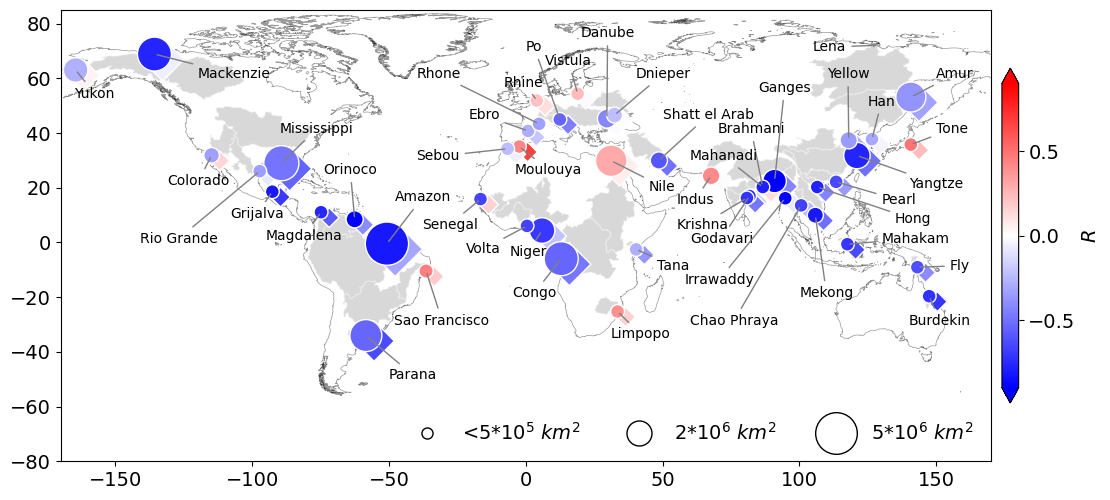

In [14]:
from geopandas import GeoDataFrame
gdf = GeoDataFrame(df_lag2['R_max'],geometry = df1['coordinate'])
gdf['basin_area'] = df1['area']
gdf['Delta'] = df1['delta']

XY_anomaly = []

for item2, item in df1.iterrows():
    XY_anomaly.append(Point(item['coordinate'].x+3,item['coordinate'].y-2))

gdf2 = GeoDataFrame(df_lag2['R_anomaly'],geometry = XY_anomaly)
gdf2['Delta'] = df1['delta']

size1 = [x if x>100 else 100 for x in df_master['basin_area']/5000]
size2 = [x if x>100 else 100 for x in df_master['basin_area']*0.8/5000]

#size2 = [x if x>0 else np.nan for x in df_master['basin_area']*0.8/5000]

gdf['size'] = size1
gdf2['size'] = size2 #to reduce the diamonds size

#world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#hymap_basin4.shp
#glob_image = rasterio.open(folder_map+'/global_map_2.5min.tiff')
#glob_data = glob_image.read()[0,:,:]
#extent = np.array([-180,180,-90,90])
#glob_data = np.where(glob_data == 255,0,1)
world = gpd.read_file(folder_map+"/globalislandsshapefile/Global_Islands.shp")
basin_gdf = gpd.read_file("/discover/nobackup/fkhadim/hymap_basin4.shp")

color = []
for c in df_lag2['R_max']:
    if c<0:
        color.append('Blue')
    else:
        color.append('Red')
        

for c in np.arange(len(df_lag2['p_val'])):
    if df_lag2['p_val'][int(c)]>0.05:
        color[c] = 'Black'        
        
color2 = []
for c in df_lag2['R_anomaly']:
    if c<0:
        color2.append('Blue')
    else:
        color2.append('Red')

for c in np.arange(len(df_lag2['p_val_anomaly'])):
    if df_lag2['p_val_anomaly'][int(c)]>0.05:
        color2[c] = 'Black'  
        

#marker = []
#for m in color: marker.append('x') if m == 'Grey' else marker.append('o')
        
fig, ax = plt.subplots(figsize = (12,6))

ax.set_aspect('equal')
ax.set_xlim([-170,170])
ax.set_ylim([-80,85])
#ax.set_xlim([-50,50])
#ax.set_ylim([25,50])



#ax[1].set_title('Correlation Coefficients of Outflow and Sea Surface Salinity')
world.plot(ax=ax, facecolor='w', edgecolor='k', alpha=0.4, lw=0.5)
basin_gdf.plot(ax=ax, facecolor='gray', alpha=0.3, edgecolor='white', lw=1)

#gdf.plot(column='R_max', ax=ax, color=color, edgecolor='yellow', 
#         markersize = np.absolute(df_lag2['R_max'])*300)
#gdf2.plot(column='R_anomaly', ax=ax, color=color2, edgecolor='yellow',
#         marker = 'D' , markersize = np.absolute(df_lag2['R_anomaly'])*300)



gdf2.plot(column='R_anomaly', ax=ax, cmap='bwr', legend= True, vmin=-0.9, vmax=0.9, 
          legend_kwds={'shrink':0.6, 'pad':0.01, 'label': '$R$', 'extend': 'both'},
          edgecolor='white', marker = 'D', markersize = 'size', lw=1)
gdf.plot(column='R_max', ax=ax, cmap='bwr', vmin=-0.9, vmax=0.9, edgecolor='white', 
         markersize = 'size', lw=1)





custom_lines = [Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=8,label = '<5*10$^5$ $km^2$'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=18,label = '2*10$^6$ $km^2$'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=30,label = '5*10$^6$ $km^2$')]

plt.legend(handles=custom_lines, loc='lower right', ncol=3, 
           fontsize = 14, frameon=False)

for ind, row in df_master.iterrows():
    ax.annotate("%s"%row['Delta'].replace('_',' '), xy=row['XY_coordinate'], 
                xytext=row['XY_annotate'], fontsize=10,
                arrowprops={"arrowstyle":"-", "color":"gray"})
                #bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8, 0.5), ec="none"),


#plt.text(-20, 20, 'o', fontsize=100, bbox=dict(facecolor='none', alpha=0.5))
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

plt.savefig('/discover/nobackup/fkhadim/Figure1_zerolag_new.png', dpi=600)

plt.show


In [76]:
df_master

,DeltaID,Delta,gridcode,MEAN_temp,dam_count,dam_area,basin_area,dam_area_percent,gauge,status,Climate_Code,Wave_H,Wave_T,Lon_gauge,Lat_gauge,gauge_area,gauge_R,gauge_stdv,XY_annotate,XY_coordinate
0,1,Amazon,1452,24.681,7,2623.2,4.853135e+06,0.054052,610238503.0,gauged,1,0.514444,2.776869,-55.5131,-1.9192,4671740.500,0.946487,0.209453,"(-48, 15)","(-50.75, -0.4500007629394531)"
1,2,Amur,3376,-0.279,6,2583.8,2.334644e+06,0.110672,NaN,ungauged,26,0.546084,2.700663,NaN,NaN,NaN,NaN,NaN,"(150, 60)","(140.75, 53.14999771118164)"
2,3,Brahmani,2028,23.938,4,53.6,4.294270e+04,0.124817,NaN,ungauged,3,0.512335,2.334714,NaN,NaN,NaN,NaN,NaN,"(70, 40)","(86.54998779296875, 20.450000762939453)"
3,4,Burdekin,2679,22.255,3,219.3,1.141075e+05,0.192187,531279841.0,gauged,3,0.690380,2.865581,147.2438,-19.7646,129877.969,0.890528,0.030431,"(140, -30)","(147.45001220703125, -19.650001525878906)"
4,5,Chao_Phraya,1355,25.462,10,725.8,1.314266e+05,0.552247,NaN,ungauged,3,0.581691,2.567522,NaN,NaN,NaN,NaN,NaN,"(60, -30)","(100.6500244140625, 13.549999237060547)"
5,6,Colorado,827,11.703,85,1486.2,6.308134e+05,0.235601,700771465.0,gauged,4,0.530530,2.422004,-111.5896,36.8646,283217.656,0.340129,0.184047,"(-131, 21)","(-114.8499755859375, 31.85000228881836)"
6,7,Congo,365,23.450,5,411.4,3.001319e+06,0.013707,NaN,ungauged,3,0.472678,2.311197,NaN,NaN,NaN,NaN,NaN,"(-5, -20)","(12.95001220703125, -5.950000762939453)"
7,8,Danube,5224,8.750,183,1256.1,9.310694e+05,0.134909,210592462.0,gauged,7,0.481778,2.327527,13.5021,48.5813,76860.469,0.746382,0.204135,"(20, 75)","(29.6500244140625, 45.250003814697266)"
8,9,Dnieper,5379,7.414,6,5685.9,6.609589e+05,0.860250,NaN,ungauged,7,0.486941,2.339205,NaN,NaN,NaN,NaN,NaN,"(40, 60)","(32.45001220703125, 46.54999923706055)"
9,10,Ebro,1762,11.900,45,272.7,9.335254e+04,0.292118,NaN,ungauged,7,0.461485,2.246699,NaN,NaN,NaN,NaN,NaN,"(-21, 45)","(0.8499755859375, 40.750003814697266)"


## Forward (positive) monthly lag. This is the Figure 1a used in paper.

In [4]:
dataset = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance.mat')
dataset_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_p.mat')

dataset_anomaly = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly.mat')
dataset_anomaly_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly_p.mat')


list_ = []
for x in dataset.keys():
    if x[0] != '_':
        list_.append(x)
        
delta=[]
R_max = []
R_anomaly = []
p_val = []
p_val_anomaly = []
optimized_distance = []
optimized_lag = []
#area = []
#mean_streamflow = []

for keys in list_:
    
    delta.append(keys)
    
    posval = np.nanmax(dataset[keys][:,3:]) #[:,3:] is for considering only positive lags # 
    negval = np.nanmin(dataset[keys][:,3:])
    if np.greater(np.abs(posval),np.abs(negval)):
        #print(posval)
        R = posval
    else:
        #print(negval)
        R = negval
    try:
        x = int(np.where(dataset[keys][:,3:]==R)[0])
        y = int(np.where(dataset[keys][:,3:]==R)[1])
    except:
        x = np.nan
        y = np.nan
        
    x1 = x+1
    y1 = y-3 #y-3
    #y1 = 0
    
    #print(keys)
    #area.append(float(df1.loc[df1['delta'] == keys]['area']))
    #mean_streamflow.append(float(df1.loc[df1['delta'] == keys]['mean']))
    
    p_m = dataset_p[keys][:,3:]
    p_m2 = dataset_anomaly_p[keys][:,3:]
    R_2 = dataset_anomaly[keys][:,3:]
    try:
        p_val.append(p_m[x,y]) 
        p_val_anomaly.append(p_m2[x,y])
        R_anomaly.append(R_2[x,y])
        
        #p_val.append(p_m[x]) 
        #p_val_anomaly.append(p_m2[x])
        #R_anomaly.append(R_2[x])
    
    except:
        p_val.append(np.nan)
        p_val_anomaly.append(np.nan)
        R_anomaly.append(np.nan)
        
    R_max.append(R)
    
    
    optimized_distance.append((x1))
    optimized_lag.append((y1))
    
    #lag.append(np.nanmax(dataset[keys]))
    #distance.append()

df_lag2 = pd.DataFrame(
    {'delta': delta,
     'R_max': R_max,
     'p_val': p_val,
     'R_anomaly': R_anomaly,
     'p_val_anomaly': p_val_anomaly,
     'optimized_distance': optimized_distance,
     'optimized_lag': optimized_lag,
     
    })

<function matplotlib.pyplot.show(close=None, block=None)>

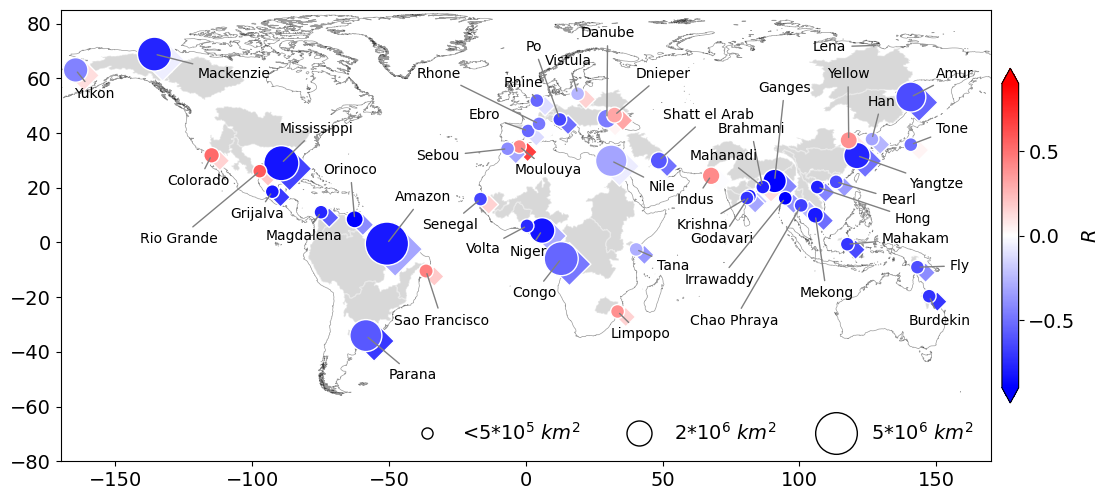

In [16]:
from geopandas import GeoDataFrame
gdf = GeoDataFrame(df_lag2['R_max'],geometry = df1['coordinate'])
gdf['basin_area'] = df1['area']
gdf['Delta'] = df1['delta']

XY_anomaly = []

for item2, item in df1.iterrows():
    XY_anomaly.append(Point(item['coordinate'].x+3,item['coordinate'].y-2))

gdf2 = GeoDataFrame(df_lag2['R_anomaly'],geometry = XY_anomaly)
gdf2['Delta'] = df1['delta']

size1 = [x if x>100 else 100 for x in df_master['basin_area']/5000]
size2 = [x if x>100 else 100 for x in df_master['basin_area']*0.8/5000]

#size2 = [x if x>0 else np.nan for x in df_master['basin_area']*0.8/5000]

gdf['size'] = size1
gdf2['size'] = size2 #to reduce the diamonds size

#world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#hymap_basin4.shp
#glob_image = rasterio.open(folder_map+'/global_map_2.5min.tiff')
#glob_data = glob_image.read()[0,:,:]
#extent = np.array([-180,180,-90,90])
#glob_data = np.where(glob_data == 255,0,1)
world = gpd.read_file(folder_map+"/globalislandsshapefile/Global_Islands.shp")
basin_gdf = gpd.read_file("/discover/nobackup/fkhadim/hymap_basin4.shp")

color = []
for c in df_lag2['R_max']:
    if c<0:
        color.append('Blue')
    else:
        color.append('Red')
        

for c in np.arange(len(df_lag2['p_val'])):
    if df_lag2['p_val'][int(c)]>0.05:
        color[c] = 'Black'        
        
color2 = []
for c in df_lag2['R_anomaly']:
    if c<0:
        color2.append('Blue')
    else:
        color2.append('Red')

for c in np.arange(len(df_lag2['p_val_anomaly'])):
    if df_lag2['p_val_anomaly'][int(c)]>0.05:
        color2[c] = 'Black'  
        

#marker = []
#for m in color: marker.append('x') if m == 'Grey' else marker.append('o')
        
fig, ax = plt.subplots(figsize = (12,6))

ax.set_aspect('equal')
ax.set_xlim([-170,170])
ax.set_ylim([-80,85])
#ax.set_xlim([-50,50])
#ax.set_ylim([25,50])



#ax[1].set_title('Correlation Coefficients of Outflow and Sea Surface Salinity')
world.plot(ax=ax, facecolor='w', edgecolor='k', alpha=0.4, lw=0.5)
basin_gdf.plot(ax=ax, facecolor='gray', alpha=0.3, edgecolor='white', lw=1)

#gdf.plot(column='R_max', ax=ax, color=color, edgecolor='yellow', 
#         markersize = np.absolute(df_lag2['R_max'])*300)
#gdf2.plot(column='R_anomaly', ax=ax, color=color2, edgecolor='yellow',
#         marker = 'D' , markersize = np.absolute(df_lag2['R_anomaly'])*300)



gdf2.plot(column='R_anomaly', ax=ax, cmap='bwr', legend= True, vmin=-0.9, vmax=0.9, 
          legend_kwds={'shrink':0.6, 'pad':0.01, 'label': '$R$', 'extend': 'both'},
          edgecolor='white', marker = 'D', markersize = 'size', lw=1)
gdf.plot(column='R_max', ax=ax, cmap='bwr', vmin=-0.9, vmax=0.9, edgecolor='white', 
         markersize = 'size', lw=1)





custom_lines = [Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=8,label = '<5*10$^5$ $km^2$'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=18,label = '2*10$^6$ $km^2$'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=30,label = '5*10$^6$ $km^2$')]

plt.legend(handles=custom_lines, loc='lower right', ncol=3, 
           fontsize = 14, frameon=False)

for ind, row in df_master.iterrows():
    ax.annotate("%s"%row['Delta'].replace('_',' '), xy=row['XY_coordinate'], 
                xytext=row['XY_annotate'], fontsize=10,
                arrowprops={"arrowstyle":"-", "color":"gray"})
                #bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8, 0.5), ec="none"),


#plt.text(-20, 20, 'o', fontsize=100, bbox=dict(facecolor='none', alpha=0.5))
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

plt.savefig('/discover/nobackup/fkhadim/Figure1_new.png', dpi=600)

plt.show


## Reverse (Negative) monthly lag. We did not use it in the paper.

In [29]:
dataset = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance.mat')
dataset_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_p.mat')

dataset_anomaly = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly.mat')
dataset_anomaly_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly_p.mat')


list_ = []
for x in dataset.keys():
    if x[0] != '_':
        list_.append(x)
        
delta=[]
R_max = []
R_anomaly = []
p_val = []
p_val_anomaly = []
optimized_distance = []
optimized_lag = []
#area = []
#mean_streamflow = []

for keys in list_:
    
    delta.append(keys)
    
    posval = np.nanmax(dataset[keys][:,0:3]) #[:,3:] is for considering only positive lags # 
    negval = np.nanmin(dataset[keys][:,0:3])
    if np.greater(np.abs(posval),np.abs(negval)):
        #print(posval)
        R = posval
    else:
        #print(negval)
        R = negval
    try:
        x = int(np.where(dataset[keys][:,0:3]==R)[0])
        y = int(np.where(dataset[keys][:,0:3]==R)[1])
    except:
        x = np.nan
        y = np.nan
        
    x1 = x+1
    y1 = y-3 #y-3
    #y1 = 0
    
    #print(keys)
    #area.append(float(df1.loc[df1['delta'] == keys]['area']))
    #mean_streamflow.append(float(df1.loc[df1['delta'] == keys]['mean']))
    
    p_m = dataset_p[keys][:,0:3]
    p_m2 = dataset_anomaly_p[keys][:,0:3]
    R_2 = dataset_anomaly[keys][:,0:3]
    try:
        p_val.append(p_m[x,y]) 
        p_val_anomaly.append(p_m2[x,y])
        R_anomaly.append(R_2[x,y])
        
        #p_val.append(p_m[x]) 
        #p_val_anomaly.append(p_m2[x])
        #R_anomaly.append(R_2[x])
    
    except:
        p_val.append(np.nan)
        p_val_anomaly.append(np.nan)
        R_anomaly.append(np.nan)
        
    R_max.append(R)
    
    
    optimized_distance.append((x1))
    optimized_lag.append((y1))
    
    #lag.append(np.nanmax(dataset[keys]))
    #distance.append()

df_lag2 = pd.DataFrame(
    {'delta': delta,
     'R_max': R_max,
     'p_val': p_val,
     'R_anomaly': R_anomaly,
     'p_val_anomaly': p_val_anomaly,
     'optimized_distance': optimized_distance,
     'optimized_lag': optimized_lag,
     
    })



<function matplotlib.pyplot.show(close=None, block=None)>

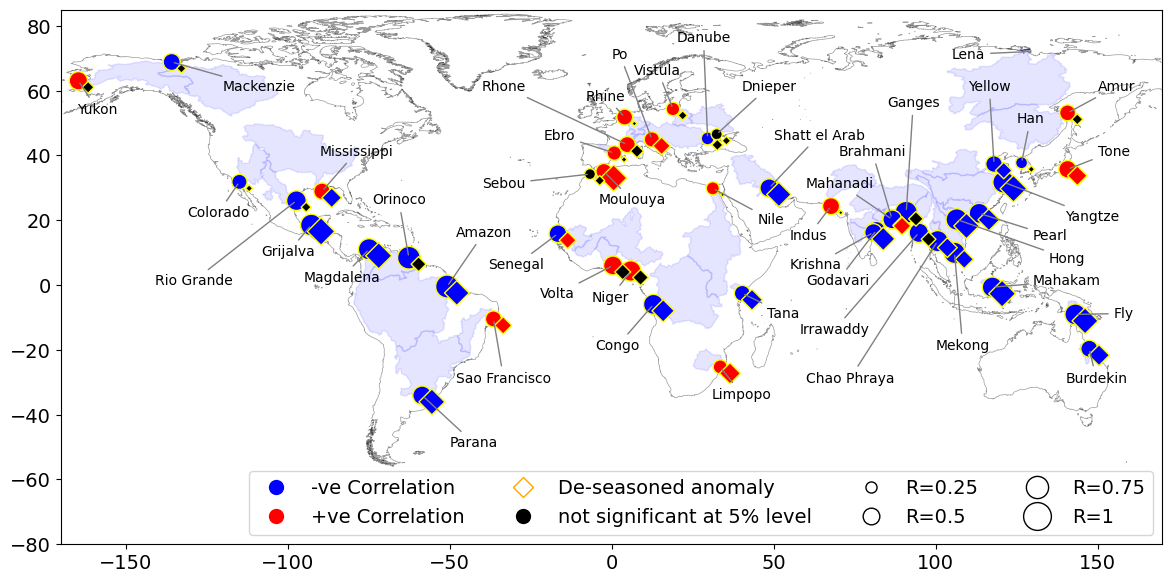

In [30]:
from geopandas import GeoDataFrame
gdf = GeoDataFrame(df_lag2['R_max'],geometry = df1['coordinate'])

XY_anomaly = []

for item2, item in df1.iterrows():
    XY_anomaly.append(Point(item['coordinate'].x+3,item['coordinate'].y-2))

gdf2 = GeoDataFrame(df_lag2['R_anomaly'],geometry = XY_anomaly)

#world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#hymap_basin4.shp
#glob_image = rasterio.open(folder_map+'/global_map_2.5min.tiff')
#glob_data = glob_image.read()[0,:,:]
#extent = np.array([-180,180,-90,90])
#glob_data = np.where(glob_data == 255,0,1)
world = gpd.read_file(folder_map+"/globalislandsshapefile/Global_Islands.shp")
basin_gdf = gpd.read_file("/discover/nobackup/fkhadim/hymap_basin4.shp")

color = []
for c in df_lag2['R_max']:
    if c<0:
        color.append('Blue')
    else:
        color.append('Red')
        

for c in np.arange(len(df_lag2['p_val'])):
    if df_lag2['p_val'][int(c)]>0.05:
        color[c] = 'Black'        
        
color2 = []
for c in df_lag2['R_anomaly']:
    if c<0:
        color2.append('Blue')
    else:
        color2.append('Red')

for c in np.arange(len(df_lag2['p_val_anomaly'])):
    if df_lag2['p_val_anomaly'][int(c)]>0.05:
        color2[c] = 'Black'  
        

#marker = []
#for m in color: marker.append('x') if m == 'Grey' else marker.append('o')
        
fig, ax = plt.subplots(figsize = (12,6))

ax.set_aspect('equal')
ax.set_xlim([-170,170])
ax.set_ylim([-80,85])
#ax.set_xlim([-50,50])
#ax.set_ylim([25,50])


#ax[1].set_title('Correlation Coefficients of Outflow and Sea Surface Salinity')
world.plot(ax=ax, facecolor='w', edgecolor='k', alpha=0.4, lw=0.5)
basin_gdf.plot(ax=ax, facecolor='blue', alpha=0.1, edgecolor='blue', lw=1)
gdf.plot(column='R_max', ax=ax, color=color, edgecolor='yellow', 
         markersize = np.absolute(df_lag2['R_max'])*300)
gdf2.plot(column='R_anomaly', ax=ax, color=color2, edgecolor='yellow',
         marker = 'D' , markersize = np.absolute(df_lag2['R_anomaly'])*300)



custom_lines = [Line2D([0], [0], color='Blue', marker='o', lw=0, markersize = 10, label = '-ve Correlation'),
                Line2D([0], [0], color='Red', marker='o', lw=0, markersize = 10, label = '+ve Correlation'),
                Line2D([0], [0], color='White', marker='D', markeredgecolor='orange', lw=1, markersize = 10,  
                       label='De-seasoned anomaly'),
                Line2D([0], [0], color='Black', marker='o', lw=0, markersize = 10, label = 'not significant at 5% level'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=8,label = 'R=0.25'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=12,label = 'R=0.5'),                
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=16,label = 'R=0.75'),
                Line2D([0], [0], markerfacecolor='none', markeredgecolor='k', marker='o', lw=0, 
                       markersize=20,label = 'R=1')]

plt.legend(handles=custom_lines, loc='lower right', ncol=4, fontsize = 14)

for ind, row in df_master.iterrows():
    ax.annotate("%s"%row['Delta'].replace('_',' '), xy=row['XY_coordinate'], 
                xytext=row['XY_annotate'], fontsize=10,
                arrowprops={"arrowstyle":"-", "color":"gray"})
                #bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8, 0.5), ec="none"),


#plt.text(-20, 20, 'o', fontsize=100, bbox=dict(facecolor='none', alpha=0.5))
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

plt.savefig('/discover/nobackup/fkhadim/Figure1_negativelag.png', dpi=600)

plt.show


# Regression slope for SSS change

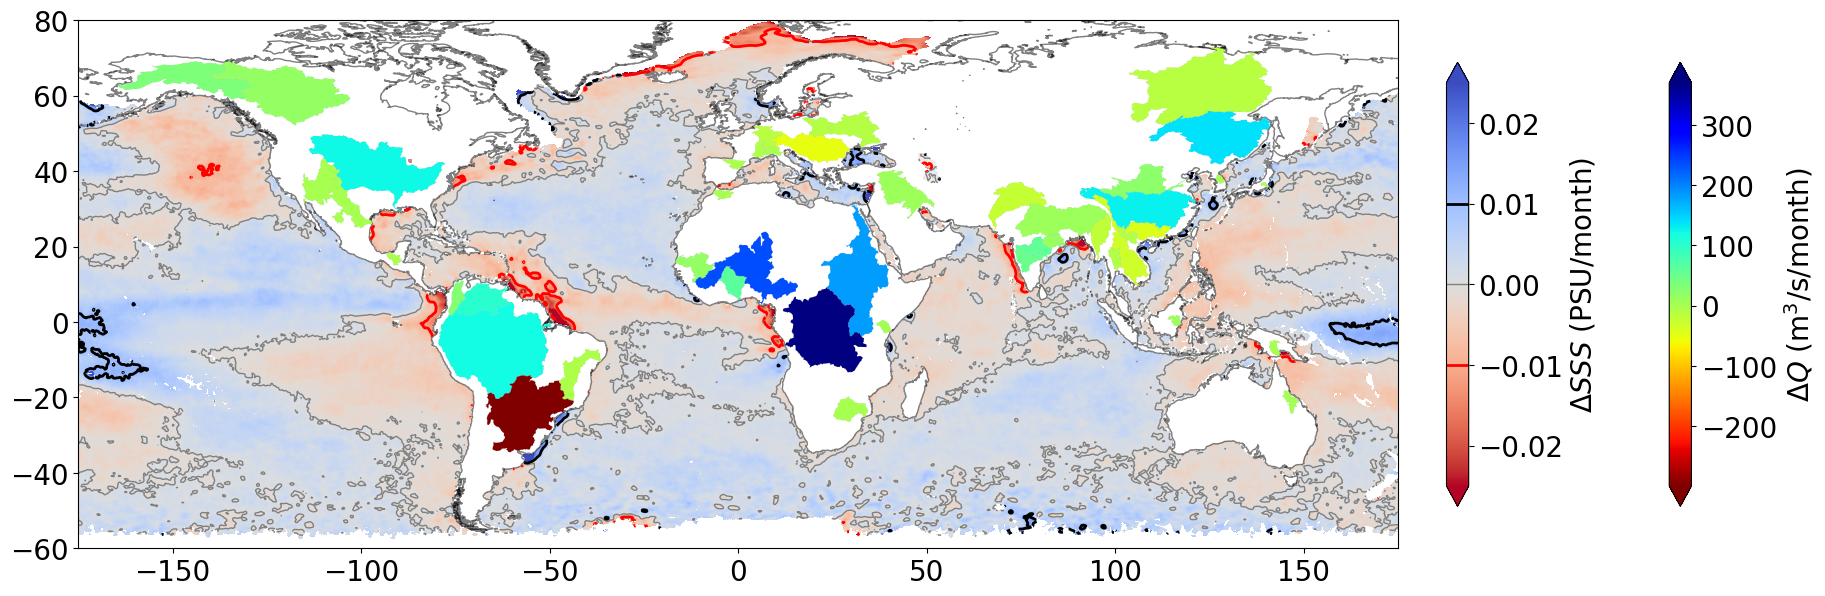

In [31]:
from scipy.stats import linregress
import xarray as xr


fig, ax = plt.subplots(figsize = (20,8))
plt.rcParams.update({'font.size': 20})

Q_slope = []
for keys in mydict.keys():
    image = mydict['%s'%(keys)]
    Q = image.Basin_Outflow
    slope, intercept, r_, p_, std_ = linregress(np.arange(79),Q[:]) 
    Q_slope.append(slope)

df_master['Q_trend'] = Q_slope

S_ = (SSS_monthly[:,:,6] - SSS_monthly[:,:,78])/6


for yy in np.arange(720):
    for xx in np.arange(1440):
        slope, intercept, r_, p_, std_ = linregress(np.arange(79),SSS_monthly[yy,xx,:]) 
        S_[yy,xx] = slope



basin_gdf = gpd.read_file("/discover/nobackup/fkhadim/hymap_basin4.shp")
basin_gdf2 = basin_gdf.merge(df_master, on='gridcode', how='outer')


extent = np.array([np.nanmin(lon2),np.nanmax(lon2),np.nanmin(lat2),np.nanmax(lat2)])
world = gpd.read_file(folder_map+"/globalislandsshapefile/Global_Islands.shp")
im2 = ax.imshow(S_,interpolation='nearest', extent=extent, cmap='coolwarm_r', vmin=-0.025, vmax=0.025)

world.plot(ax=ax, facecolor='white',edgecolor='black',alpha = 0.5, lw=1)

im1 = basin_gdf2.plot(column='Q_trend', cmap='coolwarm_r', legend=True, 
                      legend_kwds={'shrink':0.6, 'pad':-0.01, 'label': '$ΔQ$ (m$^3$/s/month)', 'extend': 'both'}, 
                      ax=ax, edgecolor='gray', lw=0.05)

#contour extent needs to be flipped
cs2 = ax.contour(S_, extent=[np.nanmin(lon2),np.nanmax(lon2),np.nanmax(lat2),np.nanmin(lat2)], 
                 levels = [-0.01,0,0.01], linewidths = [2,1,2], colors=['red','gray','black'])
cbar = fig.colorbar(im2, ax=ax, label = '$ΔSSS$ (PSU/month)', pad=0.03, extend = 'both', shrink=0.6)

cbar.add_lines(cs2)


ax.set_ylim([-60,80])
ax.set_xlim([-175,175])

#leg1 = ax.get_legend()
#leg1.set_title("land")

plt.tight_layout()

plt.savefig(nobackup+'figureX_slope_new', dpi=600)

# Figure 2

## Read hycom data (sea surface precipitation, SST, wind speed) and write .csv files

In [ ]:
# This block of code stores all the sea-surface climate attributes (precipitation, SST, wind speed) of the image objects in the dictionary "mydict"

start_time = datetime.now()
distance = [5,10,15]

for keys in mydict.keys():
    
    image = mydict['%s'%(keys)]
    
    for dist in distance:
        
        print(keys,': ',dist, 'km')
        
        image.get_hydomain(dist)
        image.get_hycom(dist)
        image.get_domain(dist)
        image.get_salinity(dist)
        image.calculate_outflow()
        image.calculate_deseasoned_anomaly()
        image.get_hycom_anomalies()
        
        precip = image.precip_ts
        surtmp = image.surtmp_ts
        wndspd = image.wndspd_ts
        salinity = image.sss_ts
        
        precip_anomaly = image.precip_ts_anomaly
        surtmp_anomaly = image.surtmp_ts_anomaly
        wndspd_anomaly = image.wndspd_ts_anomaly
        salinity_anomaly = image.sss_ts_anomaly
        
        df=pd.DataFrame({'salinity': salinity, 'precip': precip,
                         'surtmp': surtmp, 'wndspd': wndspd})
        dfa=pd.DataFrame({'salinity': salinity_anomaly, 'precip': precip_anomaly,
                         'surtmp': surtmp_anomaly, 'wndspd': wndspd_anomaly})
        df.to_csv('/discover/nobackup/fkhadim/hycom/%s_%skm.csv'%(keys,str(dist)))
        dfa.to_csv('/discover/nobackup/fkhadim/hycom/%s_%skm_anomaly.csv'%(keys,str(dist)))
        
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


Amazon :  5 km
Amazon :  10 km
Amazon :  15 km
Amur :  5 km
Amur :  10 km
Amur :  15 km


## Estimating Correlation Boxplots for Q, P, T, W

In [9]:
#Regular

In [17]:
df_master = pd.read_csv('/discover/nobackup/fkhadim/basin_data_deltas.csv')
df_master = df_master.drop(columns= ['Unnamed: 0']) #might not be needed late

dataset = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance.mat')
dataset_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_p.mat')
list_ = []
for x in dataset.keys():
    if x[0] != '_':
        list_.append(x)

df_master.head(2)


df_corr_5km = pd.DataFrame()
df_corr_10km = pd.DataFrame()
df_corr_15km = pd.DataFrame()

df_pval_5km = pd.DataFrame()
df_pval_10km = pd.DataFrame()
df_pval_15km = pd.DataFrame()

df_lag_5km = pd.DataFrame()
df_lag_10km = pd.DataFrame()
df_lag_15km = pd.DataFrame()

distance = [5,10,15]

Q_corr = [[],[], []] #three lists, for  5km, 10km, and 15km respectively
P_corr = [[],[], []]
T_corr = [[],[], []]
W_corr = [[],[], []]


Q_corr_pval = [[],[], []] #three lists, for  5km, 10km, and 15km respectively
P_corr_pval = [[],[], []]
T_corr_pval = [[],[], []]
W_corr_pval = [[],[], []]

Q_corr_lag = [[],[], []] #three lists, for  5km, 10km, and 15km respectively
P_corr_lag = [[],[], []]
T_corr_lag = [[],[], []]
W_corr_lag = [[],[], []]


files = sorted(glob2.glob(folder_hycom+'/*regular.csv'))

#reading hycom data into lists
for file in files:
    
    try:
# '/discover/nobackup/fkhadim/hycom/Rio_Grande_10km_regular.csv',
    
        Delta = file.split('/')[-1].split('_')[0]
        dist = int(file.split('km_regular')[0].split('_')[-1])

        dff =pd.read_csv(file)
        dff = dff.drop(columns=['Unnamed: 0'])
        dff = dff.dropna()
        k=stats.pearsonr(dff['precip'], dff['salinity'])[0]
        p = stats.pearsonr(dff['precip'], dff['salinity'])[1]
        l1=int(0)
#        p1=p
        
        for lag in np.arange(1,4):
            r1 = stats.pearsonr(dff['precip'][0:-lag], dff['salinity'][lag:])[0]
            if abs(r1)>abs(k):
                p1 = stats.pearsonr(dff['precip'][0:-lag], dff['salinity'][lag:])[1]
                k=r1
                l1=int(lag)
            else:
                p1=p
        r1=k
                
        k=stats.pearsonr(dff['surtmp'], dff['salinity'])[0]
        p = stats.pearsonr(dff['surtmp'], dff['salinity'])[1]
        l2=int(0)
        for lag in np.arange(1,4):
            r2 = stats.pearsonr(dff['surtmp'][0:-lag], dff['salinity'][lag:])[0]
            if abs(r2)>abs(k):
                p2 = stats.pearsonr(dff['surtmp'][0:-lag], dff['salinity'][lag:])[1]
                k=r2
                l2=int(lag)
            else:
                p2=p
        r2=k
        
        
        k=stats.pearsonr(dff['wndspd'], dff['salinity'])[0]
        p = stats.pearsonr(dff['wndspd'], dff['salinity'])[1]
        l3=int(0)
        for lag in np.arange(1,4):
            r3 = stats.pearsonr(dff['wndspd'][0:-lag], dff['salinity'][lag:])[0]
            if abs(r3)>abs(k):
                p3 = stats.pearsonr(dff['wndspd'][0:-lag], dff['salinity'][lag:])[1]
                k=r3
                l3=int(lag)
            else:
                p3=p
        r3=k
        
        P_corr[distance.index(dist)].append(r1)
        P_corr_pval[distance.index(dist)].append(p1)
        P_corr_lag[distance.index(dist)].append(l1)
        
        T_corr[distance.index(dist)].append(r2)
        T_corr_pval[distance.index(dist)].append(p2)
        T_corr_lag[distance.index(dist)].append(l2)

        W_corr[distance.index(dist)].append(r3)
        W_corr_pval[distance.index(dist)].append(p3)
        W_corr_lag[distance.index(dist)].append(l3)
    
    except:
        P_corr[distance.index(dist)].append(np.nan)
        P_corr_pval[distance.index(dist)].append(np.nan)
        P_corr_lag[distance.index(dist)].append(np.nan)

        T_corr[distance.index(dist)].append(np.nan)
        T_corr_pval[distance.index(dist)].append(np.nan)
        T_corr_lag[distance.index(dist)].append(np.nan)

        W_corr[distance.index(dist)].append(np.nan)
        W_corr_pval[distance.index(dist)].append(np.nan)
        W_corr_lag[distance.index(dist)].append(np.nan)

# read streamflow correlation

optimized_lag = []
threshold = 0.2 #statistical significancce
for key in list_:
    #print(key)
    for dist in distance:
        posval = np.nanmax(dataset[key][dist-1,3:])
        negval = np.nanmin(dataset[key][dist-1,3:])
        
        if np.greater(np.abs(posval),np.abs(negval)):
            R = posval
        else:
            R = negval
        
        try:
            tt = int(np.where(dataset[key][dist-1,3:] == R)[0])
        except:
            tt=np.nan
        print(key,dist,tt)
        optimized_lag.append(tt)
        
        Q_corr[distance.index(dist)].append(R)
        Q_corr_lag[distance.index(dist)].append(tt)
       
        try:
            Q_corr_pval[distance.index(dist)].append(dataset_p[key][dist-1,tt])
        except:
            Q_corr_pval[distance.index(dist)].append(np.nan)
      
        
#5km
df_corr_5km['streamflow'] = Q_corr[0]
df_corr_5km['precip'] = P_corr[0]
df_corr_5km['surtmp'] = T_corr[0]
df_corr_5km['wndspd'] = W_corr[0]

df_pval_5km['streamflow'] = Q_corr_pval[0]
df_pval_5km['precip'] = P_corr_pval[0]
df_pval_5km['surtmp'] = T_corr_pval[0]
df_pval_5km['wndspd'] = W_corr_pval[0]

df_lag_5km['streamflow'] = Q_corr_lag[0]
df_lag_5km['precip'] = P_corr_lag[0]
df_lag_5km['surtmp'] = T_corr_lag[0]
df_lag_5km['wndspd'] = W_corr_lag[0]

df_pval_5km_ = np.where(df_pval_5km > threshold, np.nan, 1)
df_corr_5km = pd.DataFrame(df_corr_5km*df_pval_5km_, 
                           columns=df_corr_5km.columns, index=df_corr_5km.index)

#10km
df_corr_10km['streamflow'] = Q_corr[1]
df_corr_10km['precip'] = P_corr[1]
df_corr_10km['surtmp'] = T_corr[1]
df_corr_10km['wndspd'] = W_corr[1]

df_pval_10km['streamflow'] = Q_corr_pval[1]
df_pval_10km['precip'] = P_corr_pval[1]
df_pval_10km['surtmp'] = T_corr_pval[1]
df_pval_10km['wndspd'] = W_corr_pval[1]

df_lag_10km['streamflow'] = Q_corr_lag[1]
df_lag_10km['precip'] = P_corr_lag[1]
df_lag_10km['surtmp'] = T_corr_lag[1]
df_lag_10km['wndspd'] = W_corr_lag[1]

df_pval_10km_ = np.where(df_pval_10km > threshold, np.nan, 1)
df_corr_10km = pd.DataFrame(df_corr_10km*df_pval_10km_, 
                           columns=df_corr_10km.columns, index=df_corr_10km.index)


#15km
df_corr_15km['streamflow'] = Q_corr[2]
df_corr_15km['precip'] = P_corr[2]
df_corr_15km['surtmp'] = T_corr[2]
df_corr_15km['wndspd'] = W_corr[2]

df_pval_15km['streamflow'] = Q_corr_pval[2]
df_pval_15km['precip'] = P_corr_pval[2]
df_pval_15km['surtmp'] = T_corr_pval[2]
df_pval_15km['wndspd'] = W_corr_pval[2]

df_lag_15km['streamflow'] = Q_corr_lag[2]
df_lag_15km['precip'] = P_corr_lag[2]
df_lag_15km['surtmp'] = T_corr_lag[2]
df_lag_15km['wndspd'] = W_corr_lag[2]

df_pval_15km_ = np.where(df_pval_15km > threshold, np.nan, 1)
df_corr_15km = pd.DataFrame(df_corr_15km*df_pval_15km_, 
                           columns=df_corr_15km.columns, index=df_corr_15km.index)






Amazon 5 0
Amazon 10 0
Amazon 15 0
Amur 5 2
Amur 10 0
Amur 15 3
Brahmani 5 0
Brahmani 10 0
Brahmani 15 0
Burdekin 5 0
Burdekin 10 0
Burdekin 15 0
Chao 5 0
Chao 10 0
Chao 15 0
Colorado 5 3
Colorado 10 3
Colorado 15 3
Congo 5 0
Congo 10 0
Congo 15 0
Danube 5 1
Danube 10 1
Danube 15 2
Dnieper 5 0
Dnieper 10 0
Dnieper 15 3
Ebro 5 2
Ebro 10 2
Ebro 15 2
Fly 5 0
Fly 10 0
Fly 15 0
Ganges 5 0
Ganges 10 0
Ganges 15 0
Godavari 5 1
Godavari 10 0
Godavari 15 1
Grijalva 5 0
Grijalva 10 3
Grijalva 15 3
Han 5 0
Han 10 0
Han 15 0
Hong 5 0
Hong 10 0
Hong 15 1
Indus 5 0
Indus 10 0
Indus 15 0
Irrawaddy 5 1
Irrawaddy 10 0
Irrawaddy 15 0
Krishna 5 2
Krishna 10 1
Krishna 15 1
Lena 5 nan
Lena 10 nan
Lena 15 nan
Limpopo 5 0
Limpopo 10 3
Limpopo 15 1
Mackenzie 5 nan
Mackenzie 10 nan
Mackenzie 15 0
Magdalena 5 0
Magdalena 10 0
Magdalena 15 1
Mahakam 5 0
Mahakam 10 0
Mahakam 15 0
Mahanadi 5 0
Mahanadi 10 0
Mahanadi 15 0
Mekong 5 0
Mekong 10 0
Mekong 15 0
Mississippi 5 2
Mississippi 10 2
Mississippi 15 3
Moulouya 

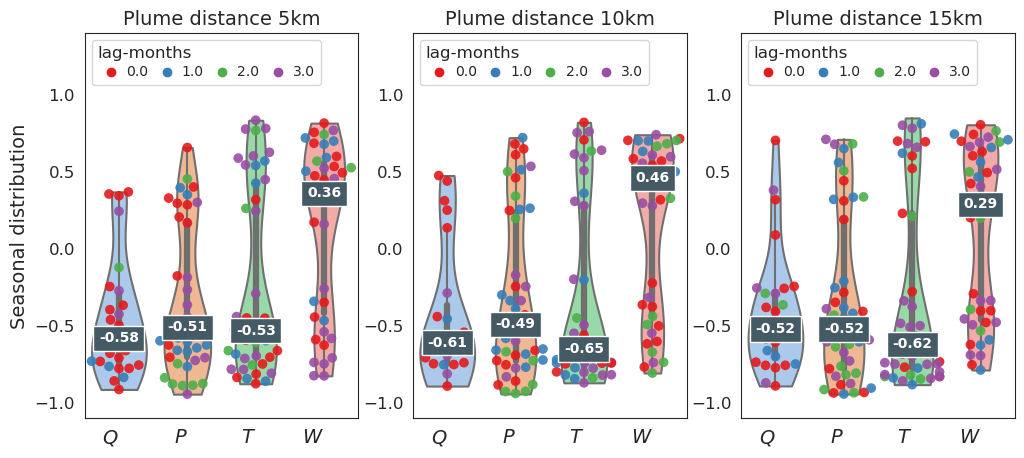

In [57]:
#sns.set()

sns.set_style("white")
fig,ax = plt.subplots(figsize=(12,5),ncols=3)

#to get the point size from the basin area
#size = np.transpose((np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0],
#                   np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])][0]),
#                   np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0],
#                   np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0]))

#size = np.transpose(np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0])


dfs = df_corr_5km.copy()
#dfs = dfs.sort_values(by=['streamflow'], ascending=False)

tag = []
for ind,row in dfs.iterrows():
    if row['streamflow']>0:
        tag.append('positive')
    elif row['streamflow']<0:
        tag.append('negative')
    else:
        tag.append('not-significant')
            
dfs['R$_{[Q,SSS]}$']  = tag 

df_long = pd.melt(dfs, id_vars=['R$_{[Q,SSS]}$'], value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')
df_long_lag = pd.melt(df_lag_5km, value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')


snsplot = sns.violinplot(dfs, palette="pastel", inner="box", ax=ax[0], cut=0)
sns.swarmplot(palette="Set1", data=df_long, x='Var', y='Val', hue=df_long_lag['Val'], ax=ax[0], 
              size=7, edgecolor='yellow', alpha = 0.9)

ax[0].legend(loc='upper left', title='lag-months', ncol=4, columnspacing=0.3, handletextpad=0.1,
             frameon=True, labelspacing=0.3, fontsize=10)._legend_box.align='left'

ax1 = snsplot.axes
categories = ax1.get_xticks()
cols = list(dfs.columns)
for handle in np.arange(4):
    y = round(np.nanmedian(dfs[cols[handle]]),2)
    ax1.text(
        handle, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
dfs = df_corr_10km.copy()
dfs = dfs.sort_values(by=['streamflow'], ascending=False)

tag = []
for ind,row in dfs.iterrows():
    if row['streamflow']>0:
        tag.append('positive')
    elif row['streamflow']<0:
        tag.append('negative')
    else:
        tag.append('not-significant')
            
dfs['R$_{[Q,SSS]}$']  = tag 

df_long = pd.melt(dfs, id_vars=['R$_{[Q,SSS]}$'], value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')
df_long_lag = pd.melt(df_lag_10km, value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')


snsplot = sns.violinplot(dfs, palette="pastel", inner="box", ax=ax[1], cut=0)
sns.swarmplot(palette="Set1", data=df_long, x='Var', y='Val', hue=df_long_lag['Val'], ax=ax[1], 
              size=7, edgecolor='yellow', alpha = 0.9)
ax[1].legend(loc='upper left', title='lag-months', ncol=4, columnspacing=0.3, handletextpad=0.1,
             frameon=True, labelspacing=0.3, fontsize=10)._legend_box.align='left'

ax1 = snsplot.axes
categories = ax1.get_xticks()
cols = list(dfs.columns)
for handle in np.arange(4):
    y = round(np.nanmedian(dfs[cols[handle]]),2)
    ax1.text(
        handle, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
    
dfs = df_corr_15km.copy()
dfs = dfs.sort_values(by=['streamflow'], ascending=False)

tag = []
for ind,row in dfs.iterrows():
    if row['streamflow']>0:
        tag.append('positive')
    elif row['streamflow']<0:
        tag.append('negative')
    else:
        tag.append('not-significant')
            
dfs['R$_{[Q,SSS]}$']  = tag 

df_long = pd.melt(dfs, id_vars=['R$_{[Q,SSS]}$'], value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')
df_long_lag = pd.melt(df_lag_15km, value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')


snsplot = sns.violinplot(dfs, palette="pastel", inner="box", ax=ax[2], cut=0)
sns.swarmplot(palette="Set1", data=df_long, x='Var', y='Val', hue=df_long_lag['Val'], ax=ax[2], 
              size=7, edgecolor='yellow', alpha = 0.9)
ax[2].legend(loc='upper left', title='lag-months', ncol=4, columnspacing=0.3, handletextpad=0.1,
             frameon=True, labelspacing=0.3, fontsize=10)._legend_box.align='left'

ax1 = snsplot.axes
categories = ax1.get_xticks()
cols = list(dfs.columns)
for handle in np.arange(4):
    y = round(np.nanmedian(dfs[cols[handle]]),2)
    ax1.text(
        handle, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
    
ax[0].set_title('Plume distance 5km', fontsize=14)
ax[1].set_title('Plume distance 10km',fontsize=14)
ax[2].set_title('Plume distance 15km',fontsize=14)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')


ax[0].set_ylim([-1.1,1.4])
ax[1].set_ylim([-1.1,1.4])
ax[2].set_ylim([-1.1,1.4])

ax[0].set_xticklabels(['$Q$', '$P$', '$T$', '$W$'], 
                      ha='right')
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=12)


ax[1].set_xticklabels(['$Q$', '$P$', '$T$', '$W$'],
                      ha='right')
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=12)

ax[2].set_xticklabels(['$Q$', '$P$', '$T$', '$W$'],
                      ha='right')
ax[2].tick_params(axis='x', labelsize=14)
ax[2].tick_params(axis='y', labelsize=12)

ax[0].set_ylabel("Seasonal distribution", fontsize=14)
ax[1].set_ylabel(" ", fontsize=14)
ax[2].set_ylabel(" ", fontsize=14)

fig.subplots_adjust(wspace=0.2)
plt.rcParams.update({'font.size': 12})

plt.savefig('/discover/nobackup/fkhadim/Figure2_main_new2.png', dpi=300)

#gca


In [51]:
#Running the same code for the Anomalies (if needed)

df_master = pd.read_csv('/discover/nobackup/fkhadim/basin_data_deltas.csv')
df_master = df_master.drop(columns= ['Unnamed: 0']) #might not be needed late

dataset = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly.mat')
dataset_p = scipy.io.loadmat('/discover/nobackup/fkhadim/dict_lag_distance_anomaly_p.mat')
list_ = []
for x in dataset.keys():
    if x[0] != '_':
        list_.append(x)

df_master.head(2)


df_corr_5km = pd.DataFrame()
df_corr_10km = pd.DataFrame()
df_corr_15km = pd.DataFrame()

df_pval_5km = pd.DataFrame()
df_pval_10km = pd.DataFrame()
df_pval_15km = pd.DataFrame()

df_lag_5km = pd.DataFrame()
df_lag_10km = pd.DataFrame()
df_lag_15km = pd.DataFrame()

distance = [5,10,15]

Q_corr = [[],[], []] #three lists, for  5km, 10km, and 15km respectively
P_corr = [[],[], []]
T_corr = [[],[], []]
W_corr = [[],[], []]


Q_corr_pval = [[],[], []] #three lists, for  5km, 10km, and 15km respectively
P_corr_pval = [[],[], []]
T_corr_pval = [[],[], []]
W_corr_pval = [[],[], []]

Q_corr_lag = [[],[], []] #three lists, for  5km, 10km, and 15km respectively
P_corr_lag = [[],[], []]
T_corr_lag = [[],[], []]
W_corr_lag = [[],[], []]


files = sorted(glob2.glob(folder_hycom+'/*anomaly.csv'))

#reading hycom data into lists
for file in files:
    
    try:
# '/discover/nobackup/fkhadim/hycom/Rio_Grande_10km_regular.csv',
    
        Delta = file.split('/')[-1].split('_')[0]
        dist = int(file.split('km_anomaly')[0].split('_')[-1])

        dff =pd.read_csv(file)
        dff = dff.drop(columns=['Unnamed: 0'])
        dff = dff.dropna()
        k=stats.pearsonr(dff['precip'], dff['salinity'])[0]
        p = stats.pearsonr(dff['precip'], dff['salinity'])[1]
        l1=int(0)
#        p1=p
        
        for lag in np.arange(1,4):
            r1 = stats.pearsonr(dff['precip'][0:-lag], dff['salinity'][lag:])[0]
            if abs(r1)>abs(k):
                p1 = stats.pearsonr(dff['precip'][0:-lag], dff['salinity'][lag:])[1]
                k=r1
                l1=int(lag)
            else:
                p1=p
        r1=k
                
        k=stats.pearsonr(dff['surtmp'], dff['salinity'])[0]
        p = stats.pearsonr(dff['surtmp'], dff['salinity'])[1]
        l2=int(0)
        for lag in np.arange(1,4):
            r2 = stats.pearsonr(dff['surtmp'][0:-lag], dff['salinity'][lag:])[0]
            if abs(r2)>abs(k):
                p2 = stats.pearsonr(dff['surtmp'][0:-lag], dff['salinity'][lag:])[1]
                k=r2
                l2=int(lag)
            else:
                p2=p
        r2=k
        
        
        k=stats.pearsonr(dff['wndspd'], dff['salinity'])[0]
        p = stats.pearsonr(dff['wndspd'], dff['salinity'])[1]
        l3=int(0)
        for lag in np.arange(1,4):
            r3 = stats.pearsonr(dff['wndspd'][0:-lag], dff['salinity'][lag:])[0]
            if abs(r3)>abs(k):
                p3 = stats.pearsonr(dff['wndspd'][0:-lag], dff['salinity'][lag:])[1]
                k=r3
                l3=int(lag)
            else:
                p3=p
        r3=k
        
        P_corr[distance.index(dist)].append(r1)
        P_corr_pval[distance.index(dist)].append(p1)
        P_corr_lag[distance.index(dist)].append(l1)
        
        T_corr[distance.index(dist)].append(r2)
        T_corr_pval[distance.index(dist)].append(p2)
        T_corr_lag[distance.index(dist)].append(l2)

        W_corr[distance.index(dist)].append(r3)
        W_corr_pval[distance.index(dist)].append(p3)
        W_corr_lag[distance.index(dist)].append(l3)
    
    except:
        P_corr[distance.index(dist)].append(np.nan)
        P_corr_pval[distance.index(dist)].append(np.nan)
        P_corr_lag[distance.index(dist)].append(np.nan)

        T_corr[distance.index(dist)].append(np.nan)
        T_corr_pval[distance.index(dist)].append(np.nan)
        T_corr_lag[distance.index(dist)].append(np.nan)

        W_corr[distance.index(dist)].append(np.nan)
        W_corr_pval[distance.index(dist)].append(np.nan)
        W_corr_lag[distance.index(dist)].append(np.nan)

# read streamflow correlation

optimized_lag = []
threshold = 0.2 #statistical significancce
for key in list_:
    #print(key)
    for dist in distance:
        posval = np.nanmax(dataset[key][dist-1,3:])
        negval = np.nanmin(dataset[key][dist-1,3:])
        
        if np.greater(np.abs(posval),np.abs(negval)):
            R = posval
        else:
            R = negval
        
        try:
            tt = int(np.where(dataset[key][dist-1,3:] == R)[0])
        except:
            tt=np.nan

        optimized_lag.append(tt)
        
        Q_corr[distance.index(dist)].append(R)
        Q_corr_lag[distance.index(dist)].append(tt)
       
        try:
            Q_corr_pval[distance.index(dist)].append(dataset_p[key][dist-1][tt])
        except:
            Q_corr_pval[distance.index(dist)].append(np.nan)
      
        
#5km
df_corr_5km['streamflow'] = Q_corr[0]
df_corr_5km['precip'] = P_corr[0]
df_corr_5km['surtmp'] = T_corr[0]
df_corr_5km['wndspd'] = W_corr[0]

df_pval_5km['streamflow'] = Q_corr_pval[0]
df_pval_5km['precip'] = P_corr_pval[0]
df_pval_5km['surtmp'] = T_corr_pval[0]
df_pval_5km['wndspd'] = W_corr_pval[0]

df_lag_5km['streamflow'] = Q_corr_lag[0]
df_lag_5km['precip'] = P_corr_lag[0]
df_lag_5km['surtmp'] = T_corr_lag[0]
df_lag_5km['wndspd'] = W_corr_lag[0]

df_pval_5km_ = np.where(df_pval_5km > threshold, np.nan, 1)
df_corr_5km = pd.DataFrame(df_corr_5km*df_pval_5km_, 
                           columns=df_corr_5km.columns, index=df_corr_5km.index)

#10km
df_corr_10km['streamflow'] = Q_corr[1]
df_corr_10km['precip'] = P_corr[1]
df_corr_10km['surtmp'] = T_corr[1]
df_corr_10km['wndspd'] = W_corr[1]

df_pval_10km['streamflow'] = Q_corr_pval[1]
df_pval_10km['precip'] = P_corr_pval[1]
df_pval_10km['surtmp'] = T_corr_pval[1]
df_pval_10km['wndspd'] = W_corr_pval[1]

df_lag_10km['streamflow'] = Q_corr_lag[1]
df_lag_10km['precip'] = P_corr_lag[1]
df_lag_10km['surtmp'] = T_corr_lag[1]
df_lag_10km['wndspd'] = W_corr_lag[1]

df_pval_10km_ = np.where(df_pval_10km > threshold, np.nan, 1)
df_corr_10km = pd.DataFrame(df_corr_10km*df_pval_10km_, 
                           columns=df_corr_10km.columns, index=df_corr_10km.index)


#15km
df_corr_15km['streamflow'] = Q_corr[2]
df_corr_15km['precip'] = P_corr[2]
df_corr_15km['surtmp'] = T_corr[2]
df_corr_15km['wndspd'] = W_corr[2]

df_pval_15km['streamflow'] = Q_corr_pval[2]
df_pval_15km['precip'] = P_corr_pval[2]
df_pval_15km['surtmp'] = T_corr_pval[2]
df_pval_15km['wndspd'] = W_corr_pval[2]

df_lag_15km['streamflow'] = Q_corr_lag[2]
df_lag_15km['precip'] = P_corr_lag[2]
df_lag_15km['surtmp'] = T_corr_lag[2]
df_lag_15km['wndspd'] = W_corr_lag[2]

df_pval_15km_ = np.where(df_pval_15km > threshold, np.nan, 1)
df_corr_15km = pd.DataFrame(df_corr_15km*df_pval_15km_, 
                           columns=df_corr_15km.columns, index=df_corr_15km.index)






# Figure 2 - extended version with wind speed

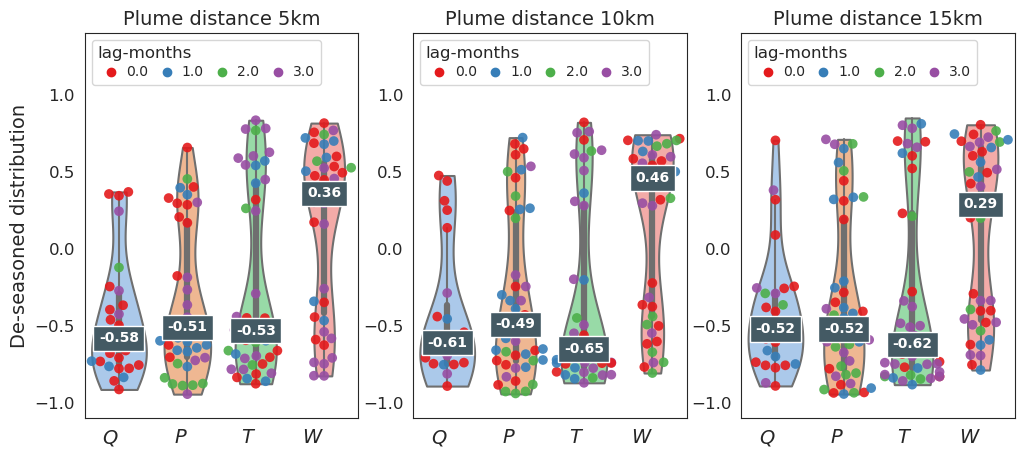

In [58]:
#sns.set()

sns.set_style("white")
fig,ax = plt.subplots(figsize=(12,5),ncols=3)

#to get the point size from the basin area
#size = np.transpose((np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0],
#                   np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])][0]),
#                   np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0],
#                   np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0]))

#size = np.transpose(np.asarray([df_master['basin_area']/np.nanmax(df_master['basin_area'])])[0])


dfs = df_corr_5km.copy()
#dfs = dfs.sort_values(by=['streamflow'], ascending=False)

tag = []
for ind,row in dfs.iterrows():
    if row['streamflow']>0:
        tag.append('positive')
    elif row['streamflow']<0:
        tag.append('negative')
    else:
        tag.append('not-significant')
            
dfs['R$_{[Q,SSS]}$']  = tag 

df_long = pd.melt(dfs, id_vars=['R$_{[Q,SSS]}$'], value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')
df_long_lag = pd.melt(df_lag_5km, value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')


snsplot = sns.violinplot(dfs, palette="pastel", inner="box", ax=ax[0], cut=0)
sns.swarmplot(palette="Set1", data=df_long, x='Var', y='Val', hue=df_long_lag['Val'], ax=ax[0], 
              size=7, edgecolor='yellow', alpha = 0.9)

ax[0].legend(loc='upper left', title='lag-months', ncol=4, columnspacing=0.3, handletextpad=0.1,
             frameon=True, labelspacing=0.3, fontsize=10)._legend_box.align='left'

ax1 = snsplot.axes
categories = ax1.get_xticks()
cols = list(dfs.columns)
for handle in np.arange(4):
    y = round(np.nanmedian(dfs[cols[handle]]),2)
    ax1.text(
        handle, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
dfs = df_corr_10km.copy()
dfs = dfs.sort_values(by=['streamflow'], ascending=False)

tag = []
for ind,row in dfs.iterrows():
    if row['streamflow']>0:
        tag.append('positive')
    elif row['streamflow']<0:
        tag.append('negative')
    else:
        tag.append('not-significant')
            
dfs['R$_{[Q,SSS]}$']  = tag 

df_long = pd.melt(dfs, id_vars=['R$_{[Q,SSS]}$'], value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')
df_long_lag = pd.melt(df_lag_10km, value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')


snsplot = sns.violinplot(dfs, palette="pastel", inner="box", ax=ax[1], cut=0)
sns.swarmplot(palette="Set1", data=df_long, x='Var', y='Val', hue=df_long_lag['Val'], ax=ax[1], 
              size=7, edgecolor='yellow', alpha = 0.9)
ax[1].legend(loc='upper left', title='lag-months', ncol=4, columnspacing=0.3, handletextpad=0.1,
             frameon=True, labelspacing=0.3, fontsize=10)._legend_box.align='left'

ax1 = snsplot.axes
categories = ax1.get_xticks()
cols = list(dfs.columns)
for handle in np.arange(4):
    y = round(np.nanmedian(dfs[cols[handle]]),2)
    ax1.text(
        handle, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
    
dfs = df_corr_15km.copy()
dfs = dfs.sort_values(by=['streamflow'], ascending=False)

tag = []
for ind,row in dfs.iterrows():
    if row['streamflow']>0:
        tag.append('positive')
    elif row['streamflow']<0:
        tag.append('negative')
    else:
        tag.append('not-significant')
            
dfs['R$_{[Q,SSS]}$']  = tag 

df_long = pd.melt(dfs, id_vars=['R$_{[Q,SSS]}$'], value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')
df_long_lag = pd.melt(df_lag_15km, value_vars=['streamflow','precip','surtmp','wndspd'],
                  var_name='Var', value_name='Val')


snsplot = sns.violinplot(dfs, palette="pastel", inner="box", ax=ax[2], cut=0)
sns.swarmplot(palette="Set1", data=df_long, x='Var', y='Val', hue=df_long_lag['Val'], ax=ax[2], 
              size=7, edgecolor='yellow', alpha = 0.9)
ax[2].legend(loc='upper left', title='lag-months', ncol=4, columnspacing=0.3, handletextpad=0.1,
             frameon=True, labelspacing=0.3, fontsize=10)._legend_box.align='left'

ax1 = snsplot.axes
categories = ax1.get_xticks()
cols = list(dfs.columns)
for handle in np.arange(4):
    y = round(np.nanmedian(dfs[cols[handle]]),2)
    ax1.text(
        handle, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
    
    
ax[0].set_title('Plume distance 5km', fontsize=14)
ax[1].set_title('Plume distance 10km',fontsize=14)
ax[2].set_title('Plume distance 15km',fontsize=14)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')


ax[0].set_ylim([-1.1,1.4])
ax[1].set_ylim([-1.1,1.4])
ax[2].set_ylim([-1.1,1.4])

ax[0].set_xticklabels(['$Q$', '$P$', '$T$', '$W$'], 
                      ha='right')
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=12)


ax[1].set_xticklabels(['$Q$', '$P$', '$T$', '$W$'],
                      ha='right')
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=12)

ax[2].set_xticklabels(['$Q$', '$P$', '$T$', '$W$'],
                      ha='right')
ax[2].tick_params(axis='x', labelsize=14)
ax[2].tick_params(axis='y', labelsize=12)

ax[0].set_ylabel("De-seasoned distribution", fontsize=14)
ax[1].set_ylabel(" ", fontsize=14)
ax[2].set_ylabel(" ", fontsize=14)

fig.subplots_adjust(wspace=0.2)


plt.savefig('/discover/nobackup/fkhadim/Figure2_extension_new2.png', dpi=300)




# Figure 3

In [12]:
Forrest_p = []
elevrange = []
Q_mean = []

#df_master = pd.DataFrame(columns = ['Delta', 'gridcode', 'Forrest_p', 
#                                    'elevrange', 'Q_mean', 'Qr', 'Qs'])

df_reservoir = pd.read_csv(nobackup+'df_reservoir.csv')
df_master = pd.merge(df_master,df_reservoir, on='Delta', how ='outer')


for key in mydict:
    image =mydict[key]
    Q_mean.append(image.mean_Outflow)
    elevrange.append(image.Elev_range)
    Forrest_p.append(image.Forrest_p)
    
    
df_master['Q_mean'] = Q_mean
df_master['elevrange'] = elevrange
df_master['Forrest_p'] = Forrest_p

#The codes below calculates the fluvial ratio. Detailed formulation is mentioned in our paper.
df_master["MEAN_temp"] = np.where(df_master["MEAN_temp"]<2,2,df_master["MEAN_temp"])

Qs = []
Qr = []

for index, row in df_master.iterrows():
    a1 = (row['Wave_H']*100)**(12/5) #wave height in cm
    b1 = row['Wave_T']**(1/5)
    
    a= (row['Q_mean'])**0.31
    b = row['basin_area']**0.5
    c = row['elevrange']/1000
    d = row['MEAN_temp']
    
    Qs.append(90*a1*b1/1000) #the original equation might yield m3/s, dividing by 1000 to convert into kg/s
    Qr.append(0.02*0.8*a*b*c*d) #assuming B = 0
    
df_master['Qs'] = Qs
df_master['Qr'] = Qr
df_master['RR'] = df_master['Qr']/df_master['Qs']


df_master['R_max'] = df_lag2['R_max']
df_master['R_anomaly'] = df_lag2['R_anomaly']
df_master['p_val'] = df_lag2['p_val']
df_master['p_val_anomaly'] = df_lag2['p_val_anomaly']
df_master['optimized_lag'] = df_lag2['optimized_lag']



In [14]:
df = df_master.copy()

color1 = []
for c in df['R_max']: #change with df1['R'] for regular correlation
    if c<0:
        color1.append('Blue')
        
    elif c>0:
        color1.append('Red')
    
    else:
        color1.append('Gray')
        
color2 = []
for c in df['R_anomaly']: #change with df1['R'] for regular correlation
    if c<0:
        color2.append('Blue')
        
    elif c>0:
        color2.append('Red')  
    else:
        color2.append('Gray')       
k = 0
for ind, row in df.iterrows():
    if row['p_val']>0.1:
        color1[k]='Gray'
    elif row['p_val_anomaly']>0.1:
        color2[k]='Gray'
    k = k+1

marker = []
for c in df['optimized_lag']: #change with df1['R'] for regular correlation
    if c>0:
        marker.append('>')       
    elif c<0:
        marker.append('<')
    else:
        marker.append('o')

HA = []
for c in df['optimized_lag']: #change with df1['R'] for regular correlation
    if c<0:
        HA.append('left')       
    elif c>0:
        HA.append('right')
        
    else:
        HA.append('center')
        
df['color1'] = color1
df['color2'] = color2
df['marker'] = marker
df['HA'] = HA

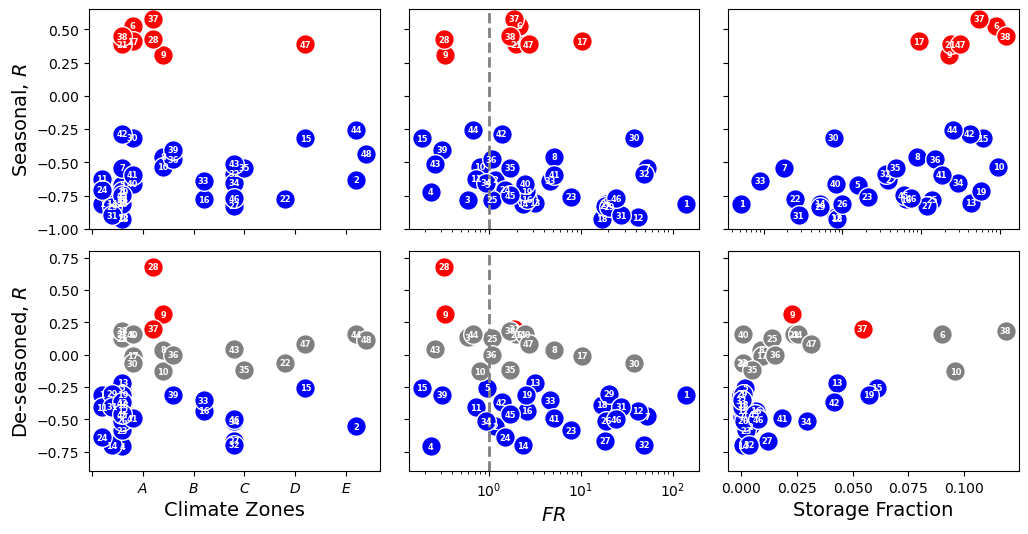

In [ ]:


#df_density = df_density.sort_values(by=['area'], ascending = True)    
fig, ax = plt.subplots(figsize=(12,6), ncols = 3, nrows = 2) ##
        
#FR

for ind, row in df.iterrows():

    im1 = ax[0][0].scatter(row['Climate_Code'], row['R_max'], color = row['color1'], edgecolor='white',
                        s=200)#
    ax[0][0].annotate(row['DeltaID'], xy=(row['Climate_Code'],row['R_max']),weight='bold', 
                   xytext=(row['Climate_Code'],row['R_max']), fontsize=6, 
                   ha = 'center',va='center', color= 'white')#, alpha=1)
    im2 = ax[0][1].scatter(row['RR'], row['R_max'], color = row['color1'], edgecolor='white',
                        s=200)
    ax[0][1].annotate(row['DeltaID'], xy=(row['RR'],row['R_max']), weight='bold',
                   xytext=(row['RR'],row['R_max']), fontsize=6, 
                   ha = 'center',va='center', color= 'white')#, alpha=1)

    im4 = ax[0][2].scatter(row['storage_fraction'], row['R_max'], color = row['color1'], edgecolor='white',
                        s=200)
    ax[0][2].annotate(row['DeltaID'], xy=(row['storage_fraction'],row['R_max']), weight='bold',
                      xytext=(row['storage_fraction'],row['R_max']), fontsize=6, 
                      ha = 'center',va='center', color= 'white')#, alpha=1)
    #anomalies
    im1 = ax[1][0].scatter(row['Climate_Code'], row['R_anomaly'], color = row['color2'], edgecolor='white',
                        s=200)
    ax[1][0].annotate(row['DeltaID'], xy=(row['Climate_Code'],row['R_anomaly']),weight='bold', 
                   xytext=(row['Climate_Code'],row['R_anomaly']), fontsize=6, 
                   ha = 'center',va='center', color= 'white')#, alpha=1)
    im2 = ax[1][1].scatter(row['RR'], row['R_anomaly'], color = row['color2'], edgecolor='white',
                        s=200)
    ax[1][1].annotate(row['DeltaID'], xy=(row['RR'],row['R_anomaly']), weight='bold',
                   xytext=(row['RR'],row['R_anomaly']), fontsize=6, 
                   ha = 'center',va='center', color= 'white')#, alpha=1)

    im4 = ax[1][2].scatter(row['storage_fraction'], row['R_anomaly'], color = row['color2'], edgecolor='white',
                        s=200)
    ax[1][2].annotate(row['DeltaID'], xy=(row['storage_fraction'],row['R_anomaly']), weight='bold',
                   xytext=(row['storage_fraction'],row['R_anomaly']), fontsize=6, 
                   ha = 'center',va='center', color= 'white')#, alpha=1)

    
ax[0][1].set_xscale("log")
ax[0][2].set_xscale("log")
#ax[0][3].set_xscale("log")
ax[0][1].axvline(1,c='grey',ls = '--', lw=2)

ax[1][0].set_ylim([-0.9, 0.8])
ax[1][1].set_ylim([-0.9, 0.8])
ax[1][2].set_ylim([-0.9, 0.8])


ax[0][0].set_xticklabels(['']) 
ax[0][1].set_xticklabels(['']) 
ax[0][2].set_xticklabels(['']) 
#ax[0][3].set_xticklabels(['']) 
ax[0][1].set_yticklabels(['']) 
ax[0][2].set_yticklabels(['']) 
#ax[0][3].set_yticklabels(['']) 

ax[1][1].set_yticklabels([''])
ax[1][2].set_yticklabels(['']) 
#ax[1][3].set_yticklabels(['']) 


ax[1][0].set_xlabel('Climate Zones', fontsize=14)
ax[1][1].set_xlabel('$FR$', fontsize=14)
ax[1][2].set_xlabel('Storage Fraction', fontsize=14)
#ax[1][3].set_xlabel('Storage Fraction', fontsize=14)

ax[0][0].set_ylabel('Seasonal, $R$', fontsize = 14)
ax[1][0].set_ylabel('De-seasoned, $R$', fontsize = 14)



ax[1][1].set_xscale("log")
ax[1][2].set_xscale("log")
#ax[1][3].set_xscale("log")
ax[1][1].axvline(1,c='grey',ls = '--', lw=2)
ax[1][0].set_xticks([0,5,10,15,20,25])
ax[1][0].set_xticklabels([' ', '$A$', '$B$', '$C$', '$D$', '$E$']), 



plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('/discover/nobackup/fkhadim/Figure3_new.png', dpi=300)


# Step 6. Extended Figures

## Summarizing Lag-distance relationship for different deltas

In [27]:
def density_plot(delta, ax, pad, title_va, xtickTrueFalse, ytickTrueFalse):
    #xticks = [-1,0,3,6,7]
    yticks = [4,9,14]
    key = delta
    
    
    X = np.where(dataset_p[key][:,3:]>0.5,np.nan, dataset[key][:,3:])
    ax.imshow(X, vmin=-1, vmax=1, cmap = 'bwr', aspect='auto')
    ax.invert_yaxis()
    ax.set_title(delta[0:10].replace('_',' '), y=1.0, pad = pad, rotation=90, va=title_va, fontsize = 13)
    #ax.set_xticks(xticks)
    
    ax.text(0,-0.2,'0    3m', fontsize=13)
    
    #ax.set_xticklabels([' ','-3','0','3',' '], fontsize = 10)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['5km','10km','15km'], fontsize = 13)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(ytickTrueFalse)
    ax.tick_params(right= False,top= False,left= False, bottom= False)
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
    
def density_plot_anomaly(delta, ax, pad, title_va, xtickTrueFalse, ytickTrueFalse):
    yticks = [4,9,14]
    key = delta
    X = np.where(dataset_anomaly_p[key][:,3:]>0.5,np.nan, dataset_anomaly[key][:,3:])
    ax.imshow(X, vmin=-1, vmax=1, cmap = 'bwr', aspect='auto')
    ax.invert_yaxis()
    ax.set_title(delta[0:10].replace('_',' '), y=1.0, pad = pad, rotation=90, va=title_va, fontsize = 13)
    #ax.set_xticks(xticks)
    
    ax.text(0,-0.2,'0    3m', fontsize=13)
    
    #ax.set_xticklabels([' ','-3','0','3',' '], fontsize = 10)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['5km','10km','15km'], fontsize = 13)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(ytickTrueFalse)
    ax.tick_params(right= False,top= False,left= False, bottom= False)
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')



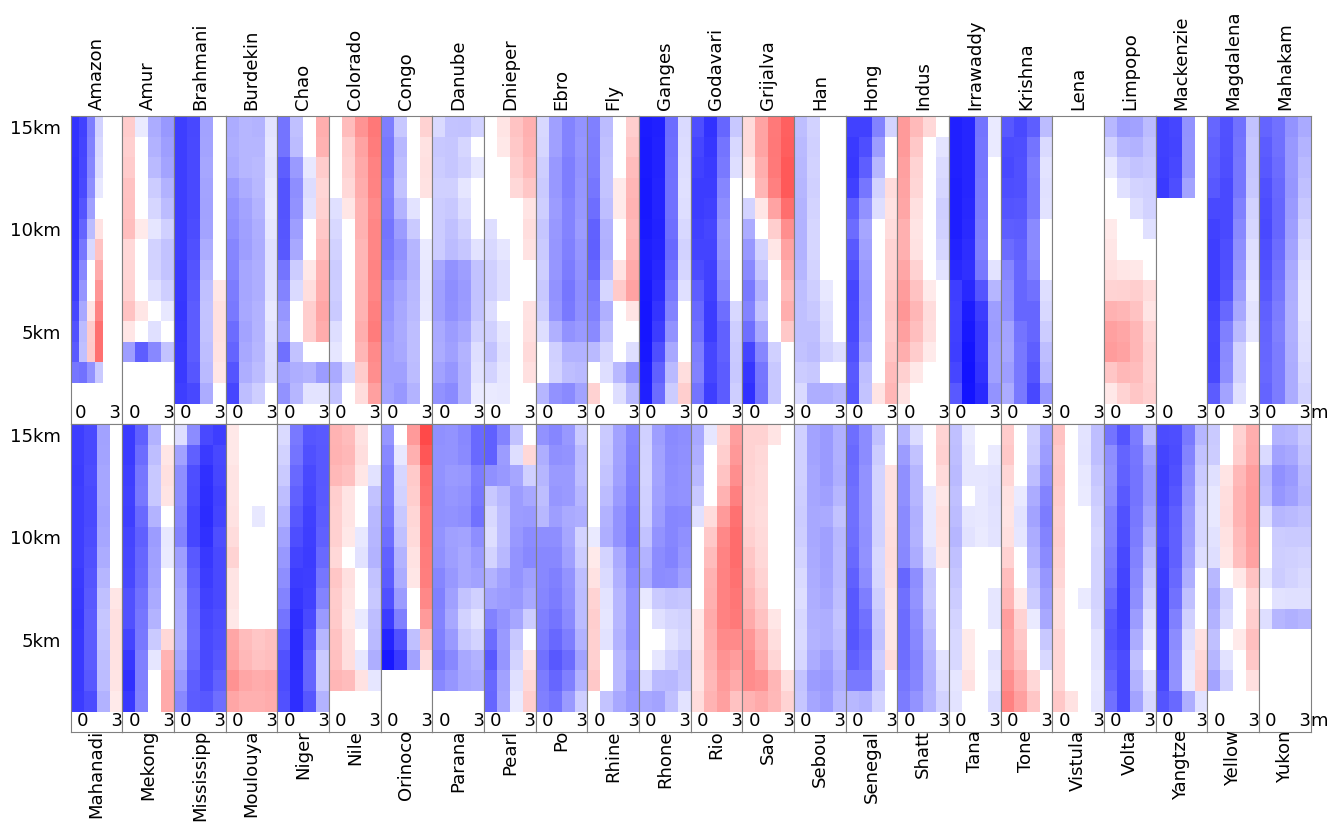

In [28]:

df_lag = df_lag2

        
f,ax = plt.subplots(figsize=(16,8), nrows=2, ncols=int(len(df_lag['delta'])/2))

index2 = np.where(np.arange(0,48)<24,0,1)


pad = [5,-220]
title_va = ['bottom', 'top']


#im = ax[0,0].imshow(dataset['Amazon'], vmin = -1, vmax = 0.6)

for index, row in df_lag.iterrows():

    x = index2[index]
    y = index

    if x==0:
        xtickTrueFalse = True
    else:
        xtickTrueFalse = False
    
    if y>=24:
        y=y-24
        
    if y==0:
        ytickTrueFalse = True
    else:
        ytickTrueFalse = False        
        
    #print(x,y)
    density_plot(row['delta'],ax[x,y],pad[x],title_va[x],xtickTrueFalse,ytickTrueFalse)

xticks = [0,6]
ax[0,0].set_xticks(xticks)

#plt.suptitle('(a) Correlation Coefficients (R) for different Lag and Plume distance', fontsize = 20)

plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig(nobackup+'FigureX_lagdist_R_new.png', dpi = 600)

#f.colorbar(im)


#plt.tight_layout()




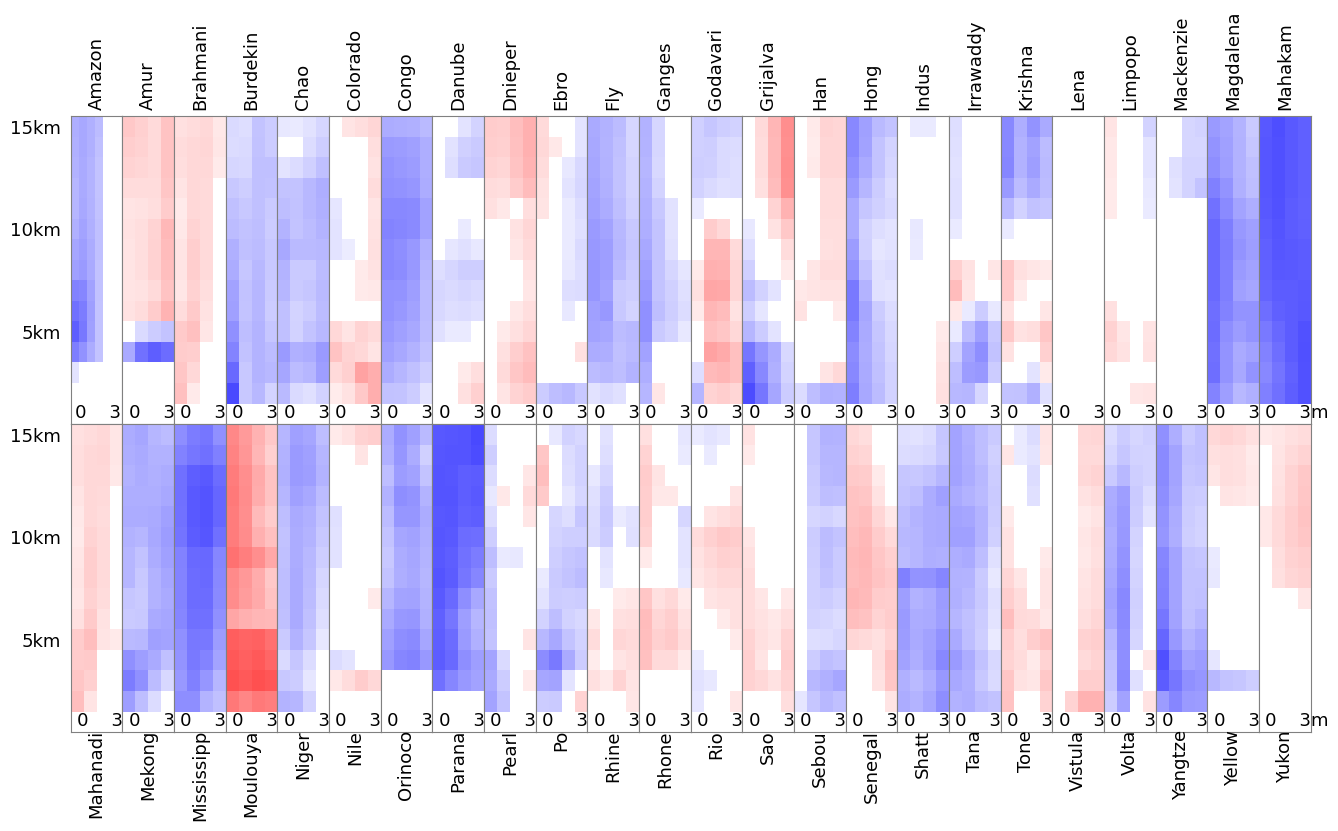

In [29]:
#Same figure, but for anomalies.

f,ax = plt.subplots(figsize=(16,8), nrows=2, ncols=int(len(df_lag['delta'])/2))

index2 = np.where(np.arange(0,48)<24,0,1)


pad = [5,-220]
title_va = ['bottom', 'top']


#im = ax[0,0].imshow(dataset['Amazon'], vmin = -1, vmax = 0.6)

for index, row in df_lag.iterrows():

    x = index2[index]
    y = index

    if x==0:
        xtickTrueFalse = True
    else:
        xtickTrueFalse = False
    
    if y>=24:
        y=y-24
        
    if y==0:
        ytickTrueFalse = True
    else:
        ytickTrueFalse = False        
        
    #print(x,y)
    density_plot_anomaly(row['delta'],ax[x,y],pad[x],title_va[x],xtickTrueFalse,ytickTrueFalse)

xticks = [0,6]
ax[0,0].set_xticks(xticks)

#plt.suptitle('(a) Correlation Coefficients (R) for different Lag and Plume distance', fontsize = 20)

plt.subplots_adjust(wspace=0,hspace=0)

plt.savefig(nobackup+'FigureX_lagdist_R_anomaly_new.png', dpi = 600)

#f.colorbar(im)

#plt.ylabel('Plume Distance in km')
#plt.tight_layout()




In [72]:
df_lag

,delta,R_max,p_val,R_anomaly,p_val_anomaly,optimized_distance,optimized_lag
0,Amazon,-0.908940,1.333549e-30,-0.527817,6.841024e-07,6.0,-1.0
1,Amur,-0.629721,7.397166e-07,-0.554199,2.450922e-05,4.0,1.0
2,Brahmani,-0.782481,1.653877e-17,0.135060,2.353242e-01,6.0,0.0
3,Burdekin,-0.719533,7.980307e-14,-0.709575,2.477502e-13,2.0,0.0
4,Chao,-0.771927,2.070629e-16,-0.335644,2.843442e-03,5.0,-2.0
5,Colorado,0.527111,9.987931e-07,0.156506,1.769795e-01,15.0,3.0
6,Congo,-0.689891,2.828472e-12,-0.433680,7.295325e-05,12.0,-1.0
7,Danube,-0.459774,2.288214e-05,0.038092,7.405647e-01,2.0,1.0
8,Dnieper,0.310408,6.352957e-03,0.310344,6.364392e-03,15.0,3.0
9,Ebro,-0.532150,6.330712e-07,-0.129309,2.623563e-01,7.0,2.0


## Gauge evaluation of HyMap streamflow 

## Read station data from Original directory (from NASA HPC)

In [47]:
df_master = pd.read_csv('/discover/nobackup/fkhadim/basin_data_deltas.csv')
df_master = df_master.drop(columns= ['Unnamed: 0']) #might not be needed later

#streamflow LIS data
lis_input=  folder_streamflow + '/lis_input_010_hybrid.nc' 
flowdir = Dataset(lis_input,'r')
lon = np.array(flowdir.variables['lon']) #longitude
lon = lon[0]
lat = np.array(flowdir.variables['lat'])
lat = np.transpose(lat)[0]

### Read the x,y of gauges in LIS network
y_lis = []
x_lis = []
gauges = []
text = []

for index, rows in df_master.iterrows():
    try:
        print(int(rows['gauge']))
        y_lis.append(np.where(np.abs(rows['Lat_gauge']-lat)<0.051))
        x_lis.append(np.where(np.abs(rows['Lon_gauge']-lon)<0.051))
        gauges.append(str(int(rows['gauge'])))
    except:
        text.append("error")
        
def gauge_readData(file):
    dates = []
    test = []
    with open(file) as f:
        lines = f.read()
        lines = lines.split('\n')
        for line in lines[:-1]:
            line = line.split('  ')
            test.append(float(line[1]))
            dates.append(line[0].replace(' ', '-'))
    return pd.DataFrame(test,index=dates, columns=['streamflow'])

def daily_to_monthly(df):
    df[df==-9999.0] = np.nan
    df.index = pd.to_datetime(df.index)
    df = df.resample('1M').mean()
    df.index = pd.to_datetime(df.index, format = '%Y-%m-%d').strftime('%Y-%m')
    
    return df

610238503
531279841
700771465
210592462
222222222
810394845
750257402
630516283
220434836
760327837
620257200
230281240
800614188


In [49]:
gauge_data_orig = {}

for gauge in gauges:
    
    try:
        file = folder_stn+'/orig/'+gauge+'.txt'    
        print(file)
        date = []
        data = []
        with open(file) as f:
            lines = f.read().split('\n')
            for line in lines[8400:-1]:
                line = line.split('\t')
                data.append(float(line[1]))
                date.append(line[0])
        
        df = pd.DataFrame(data,index=date, columns=['streamflow'])
        
        df[[df==-9999]] = np.nan
        df = df.dropna()
        gauge_data_orig[gauge] = df
        
    except:

        print("error")


/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/610238503.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/531279841.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/700771465.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/210592462.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/222222222.txt
error
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/810394845.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/750257402.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/630516283.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/220434836.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/760327837.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/620257200.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/230281240.txt
/discover/nobackup/projects/lis/STN_DATA/GLOBAL_SF/orig/800614188.txt


### Extract LIS daily streamflow data for selected gauges

In [29]:
start_time = datetime.now()

Qs_daily_dic = {}

for k in np.arange(0,13):
    Qs_daily_dic[gauges[k]] = []

for yy in np.arange(2003,2021):
    #print(yy)
    for mm in np.arange(1,13):
        mm = f"{mm:02}"
        name = '/GLOBAL_ROUTING/%s%s/'%(yy,mm)
        print(name)
        folder = folder_streamflow+name
        files=sorted(glob2.glob(folder+'/LIS_HIST*.nc'))
          
        for file in files:
            #print(file)
            array = np.asarray(Dataset(file,'r').variables['Streamflow_tavg'])
            array[array==-9999] = np.nan
            for k in np.arange(0,13):
                value = float(array[0,y_lis[k],x_lis[k]])
                Qs_daily_dic[gauges[k]].append(value)
                del value
                
scipy.io.savemat('/discover/nobackup/fkhadim/Qs_daily_dic.mat',Qs_daily_dic)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))



/GLOBAL_ROUTING/200301/


KeyboardInterrupt: 

In [50]:
Qs_daily_dic = scipy.io.loadmat('/discover/nobackup/fkhadim/Qs_daily_dic.mat')

dates_LIS = pd.date_range('2003-01-01','2020-12-31', freq='D').strftime("%Y-%m-%d").tolist()

gauge_data_taylor = {}
error = []

for index, rows in df_master.iterrows():
    try:
        print(int(rows['gauge']))
        gauge = str(int(rows['gauge']))
        Qs = Qs_daily_dic[gauge]
        Qs = Qs.flatten()
        df_lis = pd.DataFrame(Qs, columns = ['LIS_flow'])
        df_lis.index = dates_LIS
        df_insitu = gauge_data_orig[gauge]
        gauge_data_taylor[str(rows['DeltaID'])] = pd.merge(df_insitu,df_lis,left_index=True,right_index=True)
        
    except:
        error.append("error with %s"%rows['gauge'])


610238503
531279841
700771465
210592462
222222222
810394845
750257402
630516283
220434836
760327837
620257200
230281240
800614188


In [51]:
gauge_R = []
nrmse = []
error = []

for index, rows in df_master.iterrows():
    try:
        df = gauge_data_taylor[str(rows['DeltaID'])]
        #df_MsqE = np.nanmean((df['LIS_flow']-df['streamflow'])**2)
        #df_nmre = np.sqrt(np.nanmean((df['LIS_flow']-df['streamflow']-df_MsqE)**2))/np.abs(np.nanmax(df['streamflow'])-np.nanmin(df['streamflow']))#np.sqrt(df_MsqE)
        
        df_nrmse = np.sqrt(np.nanmean((df['LIS_flow']-df['streamflow'])**2))/np.nanmax(df['streamflow']-np.nanmin(df['streamflow']))
        
        R = df.corr().values[0][1]
        E = df_nrmse
        print(R,E)
        
        gauge_R.append(R)
        nrmse.append(E)
        print(str(rows['DeltaID']))
        

    except:
        error.append("error occurred %s"%rows['DeltaID'])
        
        gauge_R.append(np.nan)
        nrmse.append(np.nan)

        
df_master['gauge_R'] = gauge_R
df_master['nrmse'] = nrmse
#df_master['r_diff'] 

df_master



#df_master saved at '/discover/nobackup/fkhadim/basin_data_deltas_taylor.csv'
#the code needs to be updated to represent the correct error term

0.9429270433781523 0.19777502779164227
1
0.6107308093725837 0.05857915110087906
4
0.28058299895384825 0.17222924000911238
6
0.6282857816213082 0.055807268952464885
8
0.6453089183266841 0.14274915932350365
22
0.695309558872794 0.1465850895034991
27
0.417232481479426 0.29994839029996656
32
0.677915063218739 0.1120212694670913
35
0.1922486987647365 0.07501746250970306
37
0.514900888830595 0.3455260086173377
38
0.6034013967397308 0.27948819642990824
44
0.4955388976682066 0.15566023873064608
48


,DeltaID,Delta,gridcode,MEAN_temp,dam_count,dam_area,basin_area,dam_area_percent,gauge,status,Climate_Code,Wave_H,Wave_T,Lon_gauge,Lat_gauge,gauge_area,gauge_R,nrmse
0,1,Amazon,1452,24.681,7,2623.2,4.853135e+06,0.054052,610238503.0,gauged,1,0.514444,2.776869,-55.5131,-1.9192,4671740.500,0.942927,0.197775
1,2,Amur,3376,-0.279,6,2583.8,2.334644e+06,0.110672,NaN,ungauged,26,0.546084,2.700663,NaN,NaN,NaN,NaN,NaN
2,3,Brahmani,2028,23.938,4,53.6,4.294270e+04,0.124817,NaN,ungauged,3,0.512335,2.334714,NaN,NaN,NaN,NaN,NaN
3,4,Burdekin,2679,22.255,3,219.3,1.141075e+05,0.192187,531279841.0,gauged,3,0.690380,2.865581,147.2438,-19.7646,129877.969,0.610731,0.058579
4,5,Chao_Phraya,1355,25.462,10,725.8,1.314266e+05,0.552247,NaN,ungauged,3,0.581691,2.567522,NaN,NaN,NaN,NaN,NaN
5,6,Colorado,827,11.703,85,1486.2,6.308134e+05,0.235601,700771465.0,gauged,4,0.530530,2.422004,-111.5896,36.8646,283217.656,0.280583,0.172229
6,7,Congo,365,23.450,5,411.4,3.001319e+06,0.013707,NaN,ungauged,3,0.472678,2.311197,NaN,NaN,NaN,NaN,NaN
7,8,Danube,5224,8.750,183,1256.1,9.310694e+05,0.134909,210592462.0,gauged,7,0.481778,2.327527,13.5021,48.5813,76860.469,0.628286,0.055807
8,9,Dnieper,5379,7.414,6,5685.9,6.609589e+05,0.860250,NaN,ungauged,7,0.486941,2.339205,NaN,NaN,NaN,NaN,NaN
9,10,Ebro,1762,11.900,45,272.7,9.335254e+04,0.292118,NaN,ungauged,7,0.461485,2.246699,NaN,NaN,NaN,NaN,NaN


# Functions to Plot (had to create separate functions for axis handling)

In [33]:
from matplotlib.ticker import StrMethodFormatter

def delta_scatter_Am(ID, ax1):
    
    key = df_master[df_master['DeltaID']==ID]['Delta'][ID-1]
    image = mydict['%s'%(key)]

    df = daily_to_monthly(gauge_data_taylor[str(ID)])
    X1 = pd.to_datetime(df.index)
    

    #fig, ax1 = plt.subplots(figsize = (10,4))
    
    color = 'tab:blue'
    ax1.set_ylabel('Streamflow (m$^3$/s)', fontsize=12)
    
    ax1.plot(X1, df['streamflow'], 'k-', label = 'insitu streamflow')
    ax1.plot(X1, df['LIS_flow'], 'b-', label = 'LIS streamflow')
    #ax1.set_ylim([0,np.nanmax(df['LIS_flow']*1.2)])
    ax1.set_ylim([0,450000])
   
    ax1.legend(frameon=False, ncol=2, loc= 'upper left')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    #ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')


    color = 'tab:red'
    ax2.set_ylabel('SSS (PSU)', fontsize=12)
    
    dates = pd.date_range('2015-04-01','2021-10-01', 
                      freq='MS').strftime("%Y-%m-%d").tolist()
    X = pd.to_datetime(dates)
    Y2 = image.sss_ts    
    ax2.plot(X, Y2, 'r-', label ='SSS')
    
    ax2.set_xlim([datetime(2011, 10, 1), datetime(2021, 10, 1)])
    
    ax2.set_ylim([np.nanmin(Y2)*0.9,np.nanmax(Y2)*1.2])

    ax2.legend(frameon=False, loc ='upper right')
    ax2.set_yticks([20.0,25.0,30.0,35.0])
    
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)
    
    
def delta_scatter_Mi(ID, ax1):
    
    key = df_master[df_master['DeltaID']==ID]['Delta'][ID-1]
    image = mydict['%s'%(key)]

    df = daily_to_monthly(gauge_data_taylor[str(ID)])
    X1 = pd.to_datetime(df.index)
    

    #fig, ax1 = plt.subplots(figsize = (10,4))
    
    color = 'tab:blue'
    ax1.set_ylabel('Streamflow (m$^3$/s)', fontsize=12)
    
    ax1.plot(X1, df['streamflow'], 'k-', label = 'insitu streamflow')
    ax1.plot(X1, df['LIS_flow'], 'b-', label = 'LIS streamflow')
    #ax1.set_ylim([0,np.nanmax(df['LIS_flow']*1.2)])

   
    ax1.legend(frameon=False, loc= 'upper left')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    #ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')


    color = 'tab:red'
    ax2.set_ylabel('SSS (PSU)', fontsize=12)
    
    dates = pd.date_range('2015-04-01','2021-10-01', 
                      freq='MS').strftime("%Y-%m-%d").tolist()
    X = pd.to_datetime(dates)
    Y2 = image.sss_ts    
    ax2.plot(X, Y2, 'r-', label ='SSS')
    
    ax2.set_xlim([datetime(2011, 10, 1), datetime(2021, 10, 1)])
    
    ax2.set_ylim([np.nanmin(Y2)*0.95,np.nanmax(Y2)*1.1])

    ax2.legend(frameon=False, loc ='upper center')
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)
        
    
def delta_scatter_Co(ID, ax1):
    
    key = df_master[df_master['DeltaID']==ID]['Delta'][ID-1]
    image = mydict['%s'%(key)]

    df = daily_to_monthly(gauge_data_taylor[str(ID)])
    X1 = pd.to_datetime(df.index)
    

    #fig, ax1 = plt.subplots(figsize = (10,4))
    
    color = 'tab:blue'
    ax1.set_ylabel('Streamflow (m$^3$/s)', fontsize=12)
    
    ax1.plot(X1, df['streamflow'], 'k-', label = 'insitu streamflow')
    ax1.plot(X1, df['LIS_flow'], 'b-', label = 'LIS streamflow')
    #ax1.set_ylim([0,np.nanmax(df['LIS_flow']*1.2)])

   
    ax1.legend(frameon=False, loc= 'upper left')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    #ax1.scatter(x[:4], y[:4], s=10, c='b', marker="s", label='first')


    color = 'tab:red'
    ax2.set_ylabel('SSS (PSU)', fontsize=12)
    
    dates = pd.date_range('2015-04-01','2021-10-01', 
                      freq='MS').strftime("%Y-%m-%d").tolist()
    X = pd.to_datetime(dates)
    Y2 = image.sss_ts    
    ax2.plot(X, Y2, 'r-', label ='SSS')
    
    ax2.set_xlim([datetime(2011, 10, 1), datetime(2021, 10, 1)])
    ax1.tick_params(labelsize=12)
    ax2.tick_params(labelsize=12)
        
    ax2.set_ylim([np.nanmin(Y2),np.nanmax(Y2)])
    ax2.legend(frameon=False, loc ='upper center')
    

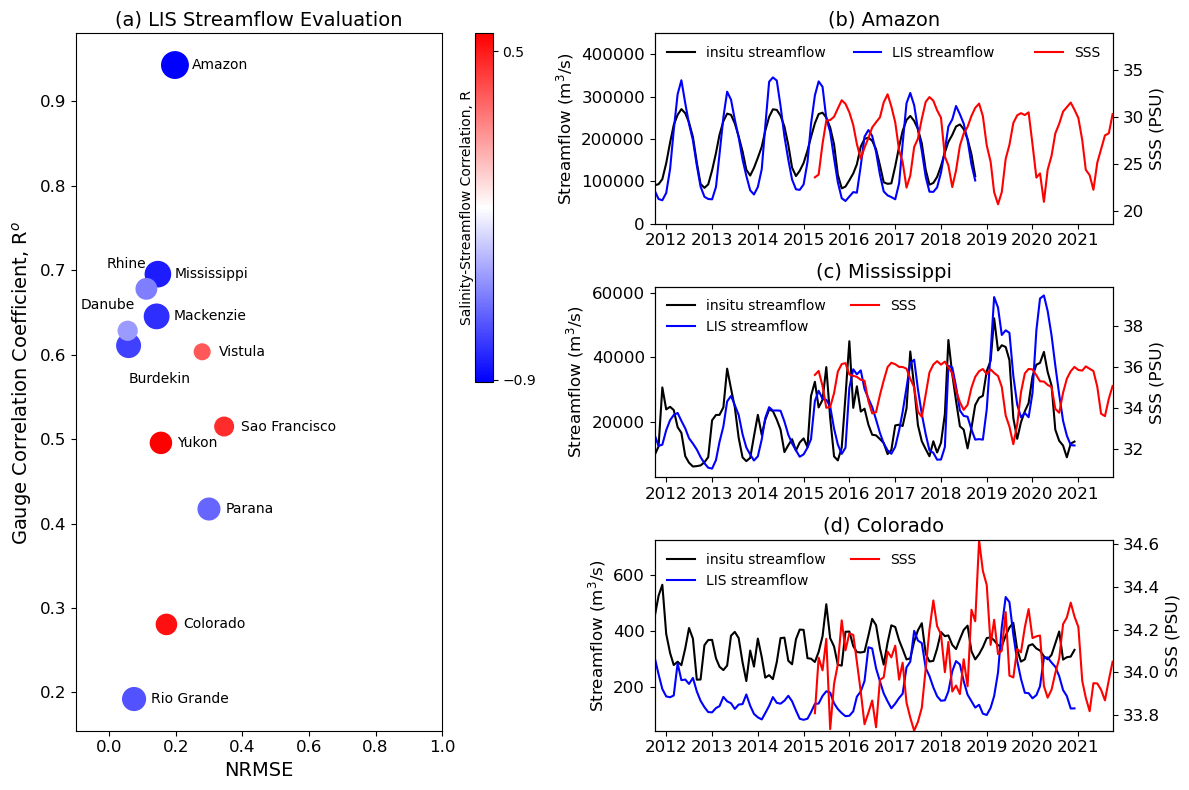

In [39]:
plt.figure(figsize=(12,8))

df = df_master[['nrmse','gauge_R','Delta', 'DeltaID', 'R_max', 'optimized_lag']].copy()
df = df.dropna()


xo=[]
yo=[]

for item in df['Delta']:
    if item == 'Rhine':
        xo.append(-0.17)
        yo.append(0.03)
    
    elif item== 'Danube':
        xo.append(-0.19)
        yo.append(0.03)            
    
    elif item== 'Burdekin':
        xo.append(-0.05)
        yo.append(-0.04)        
    
    elif item== 'Ganges':
        xo.append(-0.05)
        yo.append(-0.05)  
    
    else:
        xo.append(0)
        yo.append(0)
        
df['xo'] = xo
df['yo'] = yo


ax1 = plt.subplot(121)

#ax1 = plt.subplot(121)
ax1.scatter(df['nrmse'],df['gauge_R'])


im1 = ax1.scatter(df['nrmse'], df['gauge_R'], c = df['R_max'],cmap='bwr', 
                  vmin = np.nanmin(df['R_max']), vmax = np.nanmax(df['R_max']), s = np.abs(df['R_max'])*400)


for ind, row in df.iterrows():
    
    ax1.annotate(row['Delta'].replace('_',' '), xy=(row['nrmse'], row['gauge_R']), 
                 xytext=(row['nrmse']+row['xo']+0.05, row['gauge_R']+row['yo']), va='center', ha='left', fontsize=10)
    
ax1.set_xlim([-0.1,1])
ax1.set_xlabel('NRMSE', fontsize=14)
ax1.set_ylabel('Gauge Correlation Coefficient, R$^o$ ', fontsize=14)
ax1.tick_params(axis='y',labelsize = 12) 
ax1.tick_params(axis='x',labelsize = 12) 

cbar = fig.colorbar(im1,ticks=[-0.9,0.5], shrink=0.5, anchor = (0.2,1))
cbar.set_label('Salinity-Streamflow Correlation, R', labelpad=-55, fontsize=10)
ax1.set_title('(a) LIS Streamflow Evaluation', fontsize=14) 

ax2 = plt.subplot(322)
delta_scatter_Am(1,ax2)
ax2.set_title('(b) Amazon', fontsize=14) 


ax3 = plt.subplot(324)
delta_scatter_Mi(27,ax3)
ax3.set_title('(c) Mississippi', fontsize=14) 

#plt.plot(b, a2)

ax4 = plt.subplot(326)
delta_scatter_Co(6,ax4)
ax4.set_title('(d) Colorado', fontsize=14) 

plt.tight_layout()
#plt.plot(b, a3)

#ax1.set_title("aa")

plt.savefig(nobackup+'Figure4_old.png', dpi=600)


# Extended Figure: Reservoir Storage

In [6]:
files=sorted(glob2.glob('/discover/nobackup/projects/eis_freshwater/nbiswas/Salinity/*_sum_storage.csv'))

salbasins= ["Amazon","Amur","Brahmani","Burdekin","Chao_Phraya","Colorado","Congo","Danube","Dnieper","Ebro","Fly","Ganges","Godavari","Grijalva","Han","Hong","Indus","Irrawaddy","Krishna","Lena","Limpopo","Mackenzie","Magdalena","Mahakam","Mahanadi","Mekong","Mississippi","Moulouya","Niger","Nile","Orinoco","Parana","Pearl","Po","Rhine","Rhone","Rio_Grande","Sao_Francisco","Sebou","Senegal","Shatt_el_Arab","Tana","Tone","Vistula","Volta","Yangtze","Yellow","Yukon"]
renamebasins= ["Amazon","Amur","Brahmani","Burdekin","Chao Phraya","Colorado","Zaire","Danube","Dnieper","Ebro","Fly","Ganges-Brahmaputra","Godavari","Usumacinta","Han","Song Hong","Indus","Irrawaddy","Krishna","Lena","Limpopo","Mackenzie","Magdalena","Mahakam","Mahanadi","Mekong","Mississippi","Moulouya","Niger","Nile","Orinoco","Parana","Pearl","Po","Rhine","Rhone","Rio Grande","Sao Francisco","Sebou","Senegal","Tigris-Euphrates","Tana","Tone","Vistula","Volta","Yangtze","Hwang Ho","Yukon"]




#files.remove(remove_file[0])
date = []
deltas = []
res_storage = {}
res_volume = {}

dates_sss = pd.date_range('2015-04-01','2021-10-31', freq='M').strftime("%Y-%m").tolist()
dates_reservoir = pd.date_range('2015-01-01','2021-09-30', freq='M').strftime("%Y-%m").tolist()


for file in files:
    date = []
    data = []    
    delta = file.split('/')[-1].split('_')[0]
    idx = renamebasins.index(delta)
    delta = salbasins[idx] #renaming the delta
    #print(delta, rdelta)
    
    #print(delta)
    if delta in mydict.keys():
        deltas.append(delta)
    
        try:
            with open(file) as f:
                lines = f.read().split('\n')
                for line in lines[1:-1]:
                    line = line.split(',')
                    date.append(line[0])
                    data.append(float(line[1]))
            #print(date)
            
            date_pd = [x for x in pd.to_datetime(date)-timedelta(1)]
            dates_reservoir = pd.to_datetime(date_pd).strftime("%Y-%m").tolist()
        
            df_resservoirdata = pd.DataFrame(data,index=dates_reservoir, columns=['reservoir_volume'])

            df_resservoirdata[[df_resservoirdata==-9999]] = np.nan
            df_resservoirdata = df_resservoirdata.dropna()

            df_salinity = pd.DataFrame(mydict[delta].sss_ts,index=dates_sss, columns=['salinity'])
            months = [int(pd.Period(X).days_in_month) for X in df_salinity.index]
            #df_lisflow = pd.DataFrame(mydict[delta].Basin_Outflow*months*86400/1000000,index=dates_sss, columns=['Basin_Outflow'])
            df_lisflow = pd.DataFrame(mydict[delta].Basin_Storage,index=dates_sss, columns=['Basin_Storage'])

            res_storage[delta] = pd.merge(df_resservoirdata,df_salinity,left_index=True,right_index=True)
            res_volume[delta] = pd.merge(df_resservoirdata,df_lisflow,left_index=True,right_index=True)
           
        except Exception as error:
            print("error in", delta, ": ", error)
        
        
#for delta in deltas:
#    res_volume.corr()

In [116]:
#Create a dataframe to do boxplots of basin and reservoir volume

In [7]:
df = pd.DataFrame()
df2 = pd.DataFrame()
deltas = []
types = [] #either reservoir or basin
data = []

deltas2 = []
ratio = []

for item in res_volume:
    #print(item)
    deltas2.append(item)
    ratio.append(np.nanmean(np.asarray(res_volume[item])[:,0])/np.nanmean(np.asarray(res_volume[item])[:,1]))
    deltas.extend([item] * (len(np.asarray(res_volume[item])[:,0])*2))
    types.extend(['reservoir'] * len(np.asarray(res_volume[item])[:,0]))
    data.extend(list(np.asarray(res_volume[item])[:,0]))
    types.extend(['basin'] * len(np.asarray(res_volume[item])[:,1]))
    data.extend(list(np.asarray(res_volume[item])[:,1]))
    
df['Delta'] = deltas
df['types'] = types
df['data'] = data

df2['Delta'] = deltas2
df2['storage_fraction'] = ratio



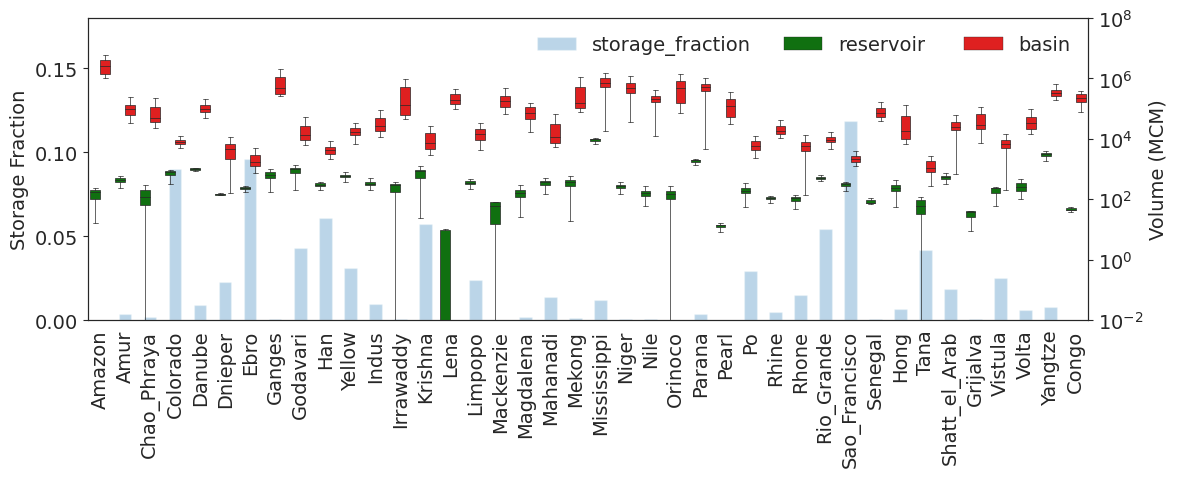

In [24]:
sns.set_style("white")

f, ax = plt.subplots(figsize=(12,5))


df2.plot.bar(x ="Delta",
             y ="storage_fraction", 
             ax=ax, alpha=0.3)
ax.set_ylabel('Storage Fraction')
#ax.set_yscale("log")
ax.legend(frameon=False, bbox_to_anchor=(0.18, 0.5, 0.5, 0.5))
#ax.set_ylim([0.01, 10])
ax.set_ylim([0, 0.18])
ax.set_xlabel('')

ax1 = ax.twinx()

sns.boxplot(x ="Delta",
            y ="data", 
            hue ="types",
            data = df,
            ax=ax1, showfliers=False, palette={"reservoir": "green", "basin": "red"}, linewidth=0.5)


ax1.set_yscale("log")
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylabel('Volume (MCM)')
ax1.set_xlabel('')
ax1.set_ylim([0.01, 100000000])
ax1.legend(frameon=False, ncol = 2, bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

plt.rcParams.update({'font.size': 14})

plt.tight_layout()
plt.savefig(nobackup+'storage_fraction.png', dpi=600)